# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import time

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Azdias Subset: Rows ,  Columns:', azdias.shape)
print('Azdias Feature Summary: Rows, Columns:' ,feat_info.shape)


Azdias Subset: Rows ,  Columns: (891221, 85)
Azdias Feature Summary: Rows, Columns: (85, 4)


In [4]:
#Print the first few rows of data
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [5]:
#Print the first few rows of data in the second dataframe.
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
#Some general statistics on the first dataframe
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
#Some statistics on the second data frame.
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ZABEOTYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
#Check the type of the missing or unknown results and print one result.
print(type(feat_info['missing_or_unknown'][0]))
print(feat_info['missing_or_unknown'][0])

<class 'str'>
[-1,0]


The code above shows that although it appears to be a list, it's actually a string. This needs to be split and converted to a list. The code below will split it on a comma and convert it to a list and replace the original column with this new list. 
Then the type is checked and it confirms it is now a list. The first values are printed and the last few records to check that the code worked correctly.

In [9]:
#Convert the string to a list and replace the original column.
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))



In [10]:
#Confirms this is changed to a list. Prints a few results.
print(type(feat_info['missing_or_unknown'][0]))
print(feat_info['missing_or_unknown'][0])
print(feat_info.tail(6))

<class 'list'>
['-1', '0']
      attribute information_level     type missing_or_unknown
79  PLZ8_BAUMAX    macrocell_plz8    mixed            [-1, 0]
80     PLZ8_HHZ    macrocell_plz8  ordinal               [-1]
81     PLZ8_GBZ    macrocell_plz8  ordinal               [-1]
82       ARBEIT         community  ordinal            [-1, 9]
83  ORTSGR_KLS9         community  ordinal            [-1, 0]
84     RELAT_AB         community  ordinal            [-1, 9]


The features dictionary will specify which values are missing. Those will be replaced with not a number. This will check the first column as a sample to see how much clean up needs to be done. 
According to the data dictionary, values of -1 and 0 are considered missing for this column. 

In [11]:
#Data Dictionary specifies values of -1, 0 are missing for Ager_typ column.
my_missing = 0
other = 0 
blank = 0
my_null = 0
for value in azdias['AGER_TYP']:
    if value == 0 or value == -1:
        my_missing += 1
    elif value == '':
        blank += 0
    else:
        other += 1
print("Missing:", my_missing,"Blank:", blank, "Null", my_null, "Other Values:", other)

Missing: 685843 Blank: 0 Null 0 Other Values: 205378


The first column is missing over 685K in values according to the data dictionary. There are only 205K values left to use. This column will have a lot of numbers to replace with NAN, but won't be usable in the final analysis because too much data is missing.
In the below code, the values that are in the data dictionary are replaced with NAN. First, a copy is made of the original azdias table. Then the attribute and missing or unknown lists are zipped together and when a matching value is found, it's replaced with nan.
To have an idea of what is missed, the nulls and value counts are added. 
This chunk takes a long time to run. 

In [12]:
# Make a new dataframe and update and count all missing values:
azdias_nan = azdias.copy()

for attribute, missing_vals in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    
    for value in missing_vals:
        if value != '' and (value.isnumeric() == True or value.lstrip('-').isdigit()):
            int_value = int(value)
            azdias_nan.loc[azdias_nan[attribute] == int_value, attribute ] = np.nan
        elif value != '' :
            azdias_nan.loc[azdias_nan[attribute] == value, attribute ] = np.nan
              
    
    
        



We can see the new min in AGER_TYP is 1 so it removed the 0, -1. The statistics have changed for many columns. We can see the counts have decreased for a lot of the columns.

In [13]:
azdias_nan.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


This shows the new value counts for that first column. The -1 and 0 are now gone from the results. 

In [14]:
azdias_nan['AGER_TYP'].value_counts(dropna = False)



NaN     685843
 2.0     98472
 1.0     79802
 3.0     27104
Name: AGER_TYP, dtype: int64

The total count of null values in the new data frame.

In [15]:
print(str(azdias_nan.isnull().sum().sum()))

8373929


Check to see the percentage of data missing for each column to identify what won't be usable in the analysis.
<ul>
<li>The first section will show the columns that need to be dropped for inadequate data. </li>
<li> The second section must have a forced entry because no values were missed. </li>
<li> The third section shows the remaining results. These may need imputing or other data corrections </li>
    </ul>

In [16]:
print("Drop these Columns:")

for attribute in azdias_nan:
    null_val = azdias_nan[attribute].isnull().sum()
    total_val = 891221
    missing_percent = round((null_val / total_val) * 100 , 1)

#Changed from version 1 where I only removed 40%. Per reviewer, take it to 25-30 to remove 6 columns.
    if missing_percent > 30:
        print(attribute, "Missing: {} %".format(missing_percent))


Drop these Columns:
AGER_TYP Missing: 77.0 %
GEBURTSJAHR Missing: 44.0 %
TITEL_KZ Missing: 99.8 %
ALTER_HH Missing: 34.8 %
KK_KUNDENTYP Missing: 65.6 %
KBA05_BAUMAX Missing: 53.5 %


In [17]:
print("100% Complete:")

complete_count = 0 
for attribute in azdias_nan:
    null_val = azdias_nan[attribute].isnull().sum()
    if null_val  == 0:
        complete_count += 1
        print(attribute)
print("Total Columns Complete: " , complete_count)


100% Complete:
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP
Total Columns Complete:  24


In [18]:
print("Remaining Columns:")

remains_count = 0
avg_percent_missing = 0
for attribute in azdias_nan:
    null_val = azdias_nan[attribute].isnull().sum()
    total_val = 891221
    missing_percent = round((null_val / total_val) * 100 , 1)
    
    
    if missing_percent <= 25 and missing_percent != 0:
        print(attribute, "Missing: {} %".format(missing_percent))
        remains_count += 1
        avg_percent_missing = missing_percent + avg_percent_missing

print("Count of Columns needing More Wrangling:", remains_count)
print("Average Percentage Missing from These Columns:", avg_percent_missing / remains_count)
    


Remaining Columns:
ALTERSKATEGORIE_GROB Missing: 0.3 %
CJT_GESAMTTYP Missing: 0.5 %
GFK_URLAUBERTYP Missing: 0.5 %
HEALTH_TYP Missing: 12.5 %
LP_LEBENSPHASE_FEIN Missing: 11.0 %
LP_LEBENSPHASE_GROB Missing: 10.6 %
LP_FAMILIE_FEIN Missing: 8.7 %
LP_FAMILIE_GROB Missing: 8.7 %
LP_STATUS_FEIN Missing: 0.5 %
LP_STATUS_GROB Missing: 0.5 %
NATIONALITAET_KZ Missing: 12.2 %
PRAEGENDE_JUGENDJAHRE Missing: 12.1 %
RETOURTYP_BK_S Missing: 0.5 %
SHOPPER_TYP Missing: 12.5 %
SOHO_KZ Missing: 8.2 %
VERS_TYP Missing: 12.5 %
ANZ_PERSONEN Missing: 8.2 %
ANZ_TITEL Missing: 8.2 %
HH_EINKOMMEN_SCORE Missing: 2.1 %
W_KEIT_KIND_HH Missing: 16.6 %
WOHNDAUER_2008 Missing: 8.2 %
ANZ_HAUSHALTE_AKTIV Missing: 11.2 %
ANZ_HH_TITEL Missing: 10.9 %
GEBAEUDETYP Missing: 10.5 %
KONSUMNAEHE Missing: 8.3 %
MIN_GEBAEUDEJAHR Missing: 10.5 %
OST_WEST_KZ Missing: 10.5 %
WOHNLAGE Missing: 10.5 %
CAMEO_DEUG_2015 Missing: 11.1 %
CAMEO_DEU_2015 Missing: 11.1 %
CAMEO_INTL_2015 Missing: 11.1 %
KBA05_ANTG1 Missing: 15.0 %
KBA05_ANTG

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

The below set of graphs gives us an idea of the distribution of the data. 
Above, we identified five columns that were missing over 40% of the data, such as AGER_TYP. Very few of these have a normal distribution. ALTER_HH is close and skewed left. GEBURTSJAHR is the most normal. 

In [19]:
#Print the value counts and make a historgram
def val_counts(column_name, bin_no, size1, size2):
    print(azdias_nan[column_name].value_counts())
    azdias_nan.hist(column = column_name, bins= bin_no, figsize = (size1, size2))
    plt.show()
                    

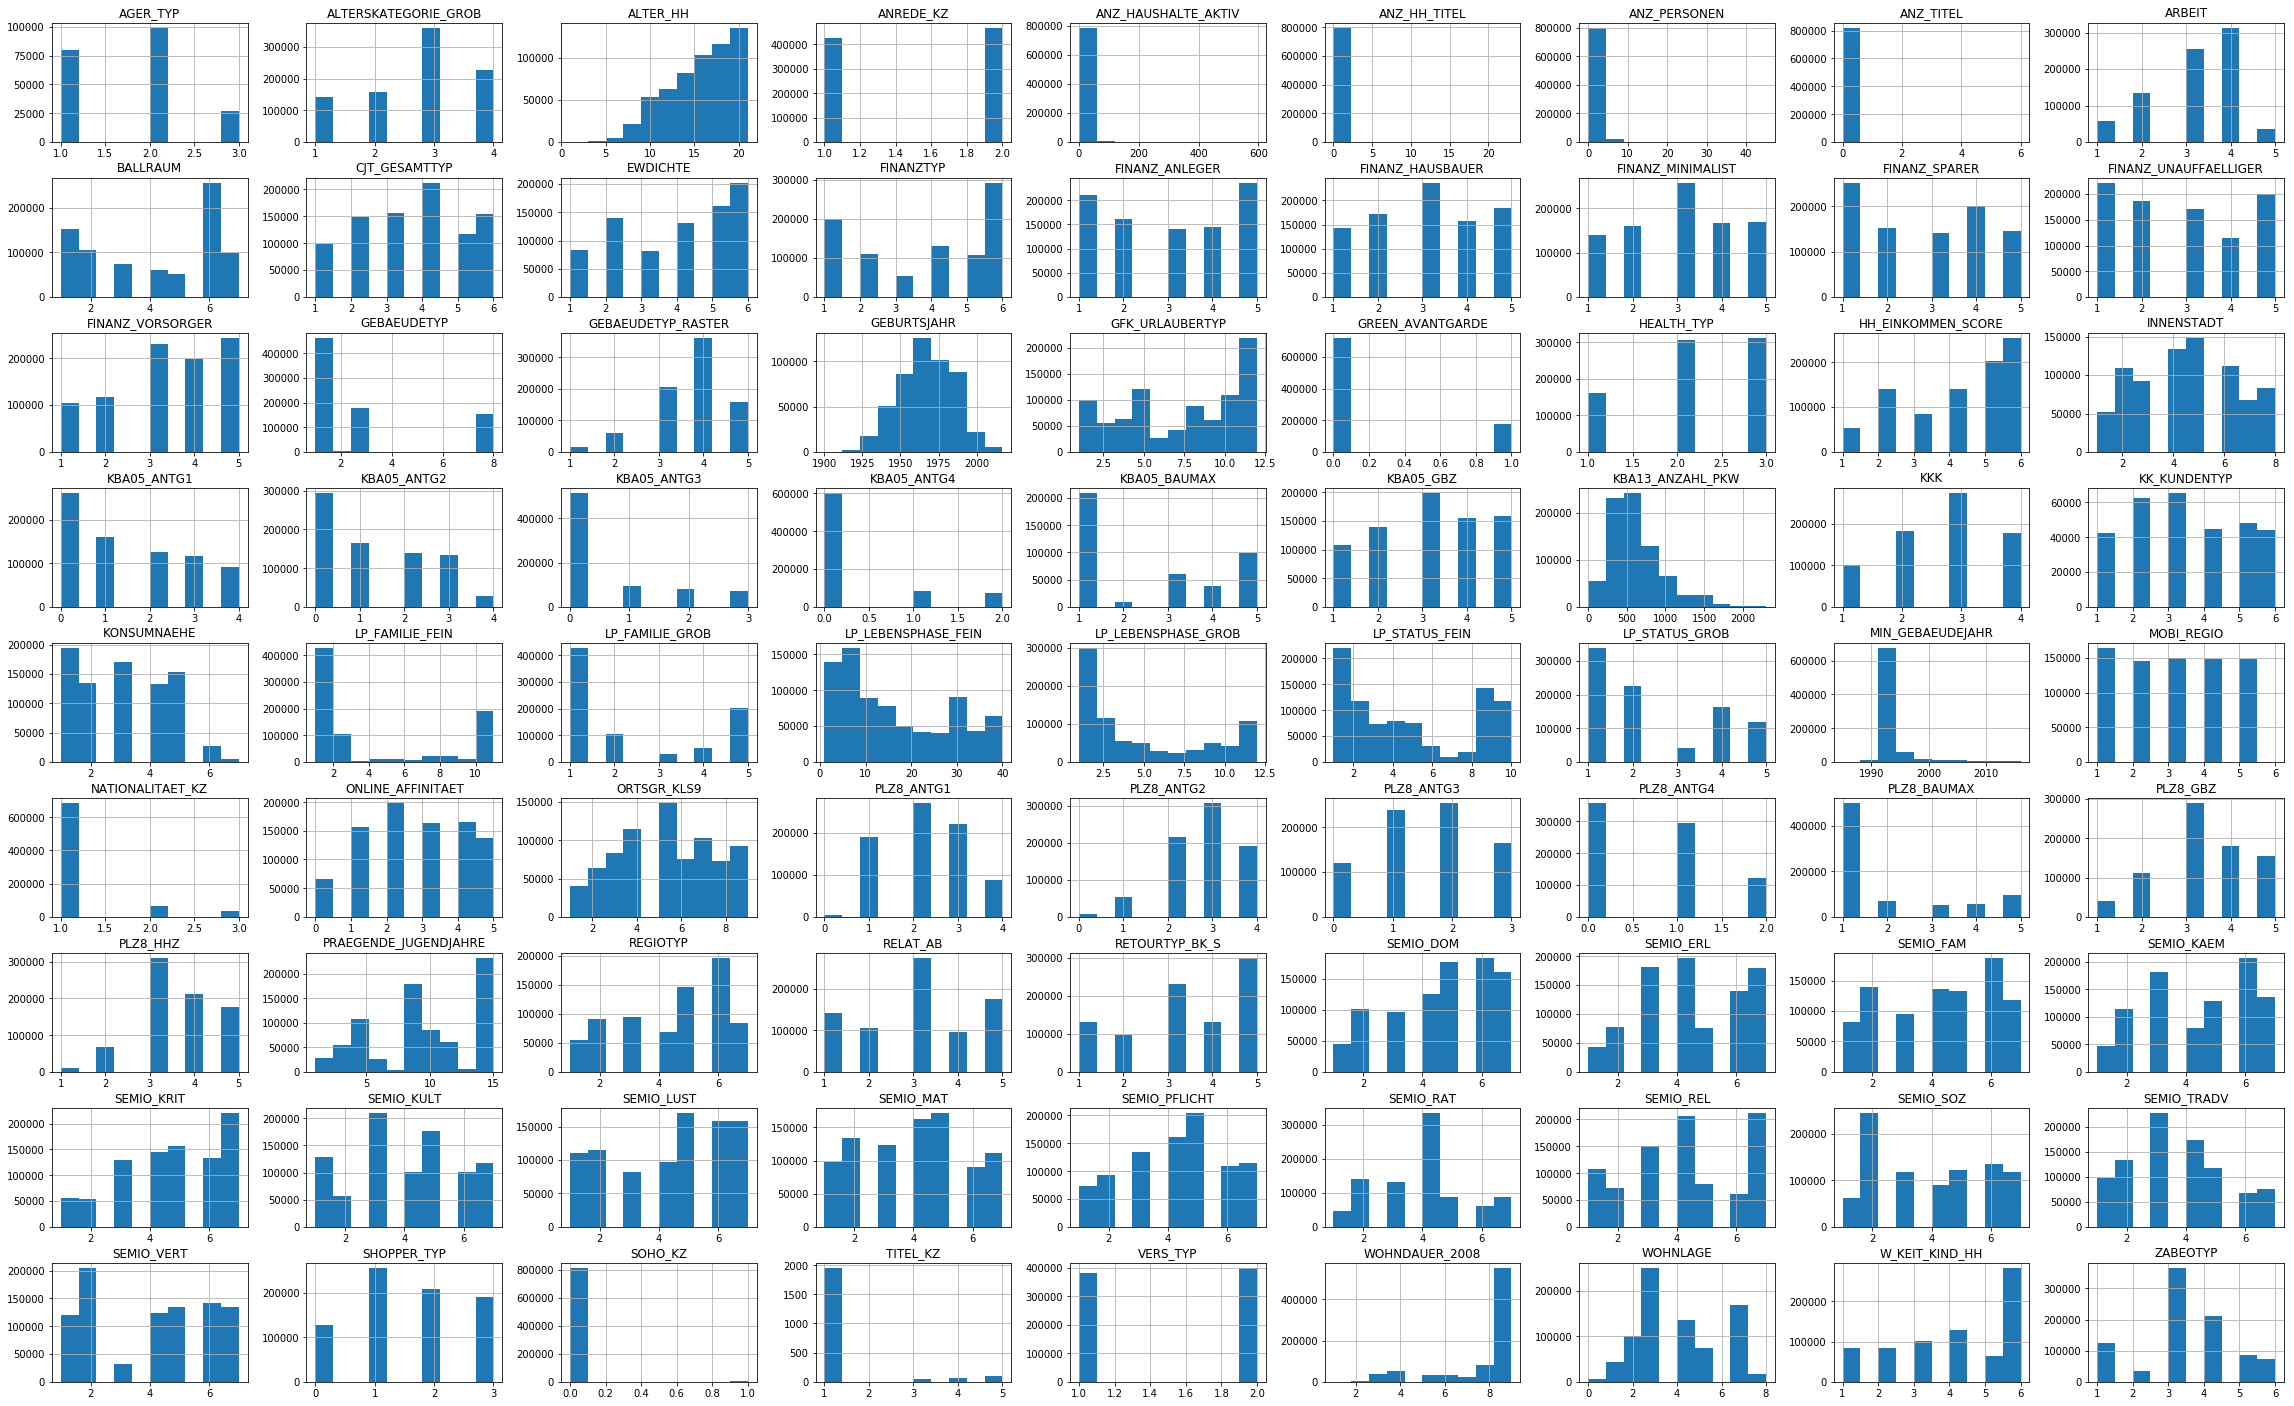

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_nan.hist(figsize = (40, 25))
plt.show()


Some graphs, like ANZ_TITEL, have only one bar. Looking closer, the majority of the values are 0. Less than 1% of the remaining values are other values. The 6 would be an outlier. Because we don't know what any of these columns are really telling us, we can only use the information in the graphs and statistics to determine why. We don't have any context. 

0.0    814542
1.0      2970
2.0       202
3.0         5
4.0         2
6.0         1
Name: ANZ_TITEL, dtype: int64


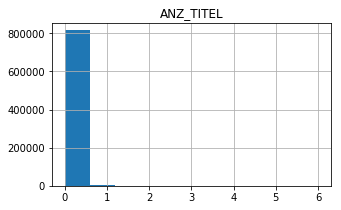

In [21]:
val_counts('ANZ_TITEL', 10, 5, 3)

Some of the columns like ORTSGR_KLS9 have a large gap in the middle. Once bin size is changed, it looks more normal. 

5.0    148096
4.0    114909
7.0    102866
9.0     91879
3.0     83542
6.0     75995
8.0     72709
2.0     63362
1.0     40589
Name: ORTSGR_KLS9, dtype: int64


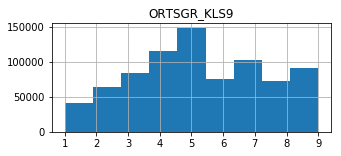

In [22]:
val_counts('ORTSGR_KLS9', 9, 5, 2)

Finally some graphs seem to have extreme values on both sides. Like ANREDE_KZ. ANREDE_KZ is 100% complete,
but only has two values. They are split almost equally.

2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64


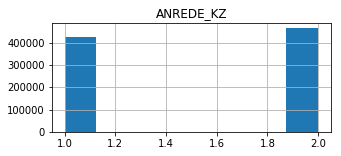

In [23]:
val_counts('ANREDE_KZ', 8, 5, 2)

These charts have less than or equal to 25% of the data missing.  It also pulled out charts with complete data.

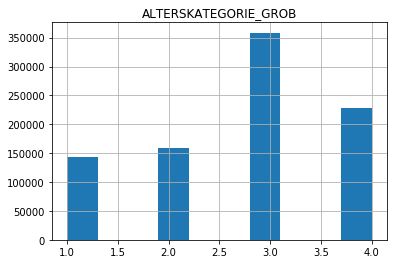

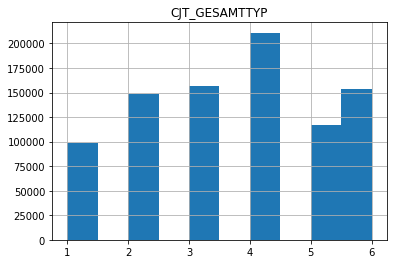

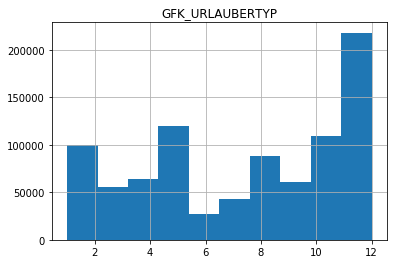

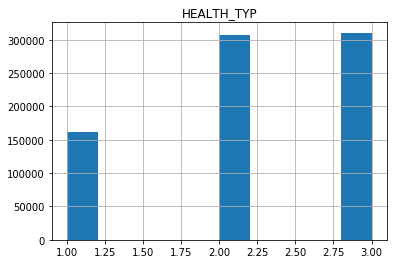

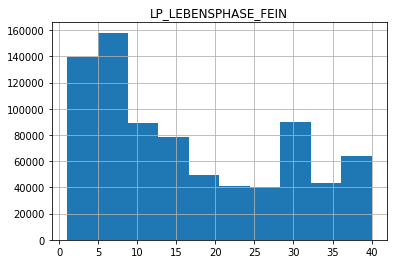

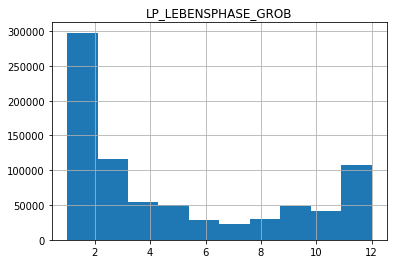

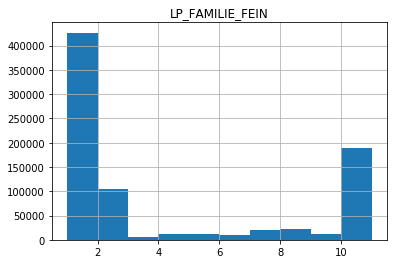

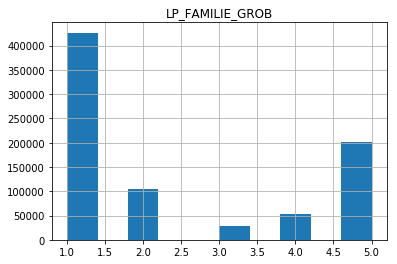

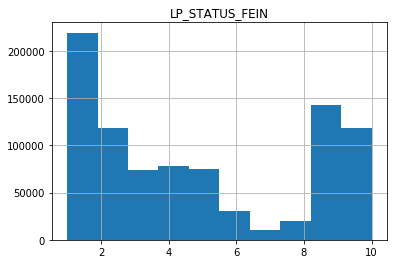

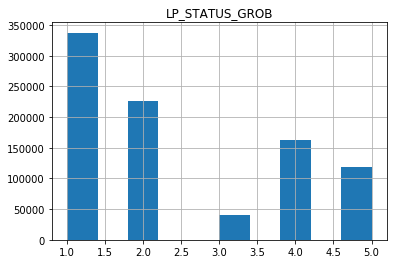

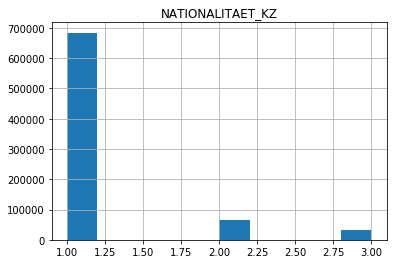

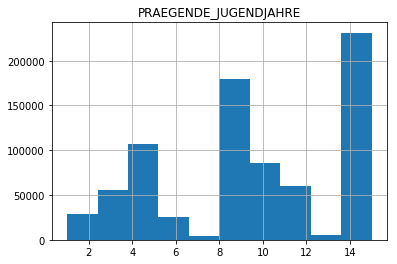

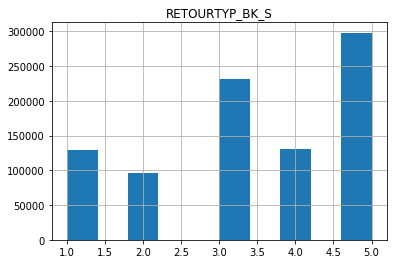

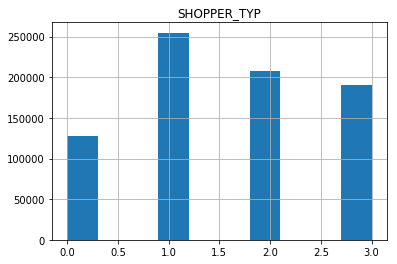

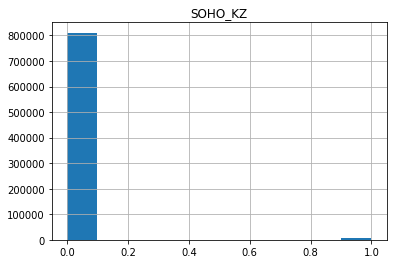

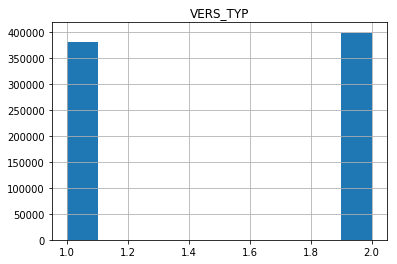

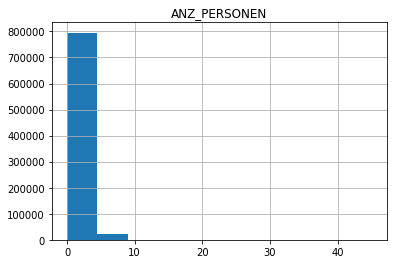

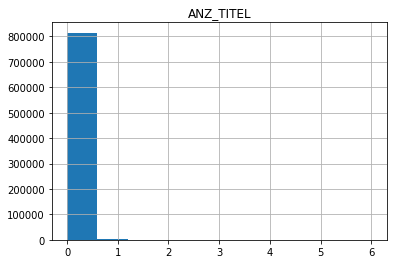

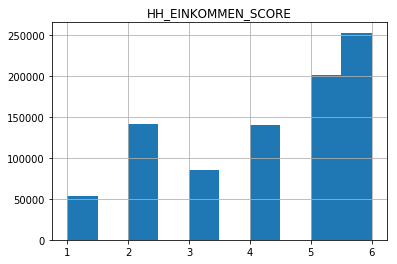

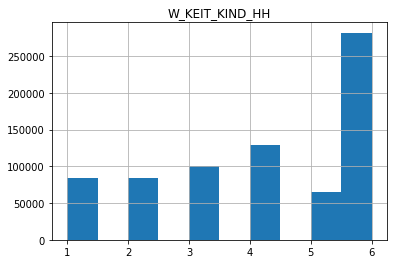

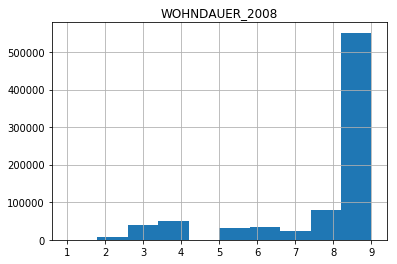

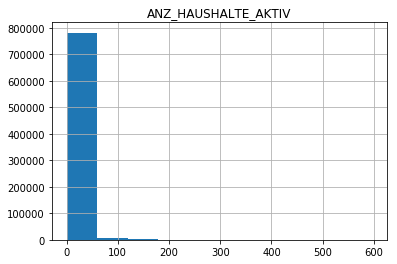

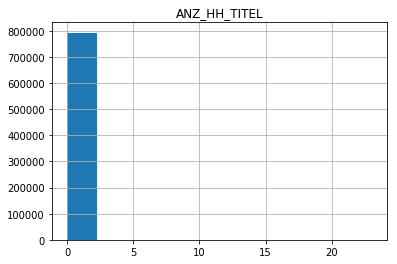

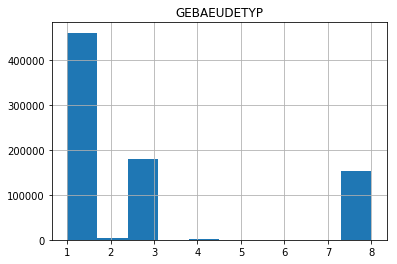

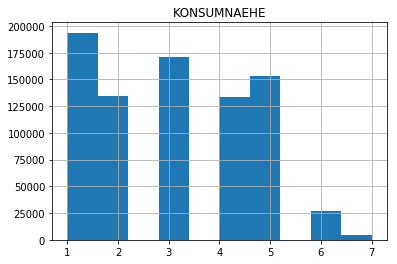

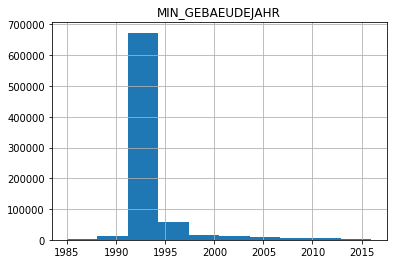

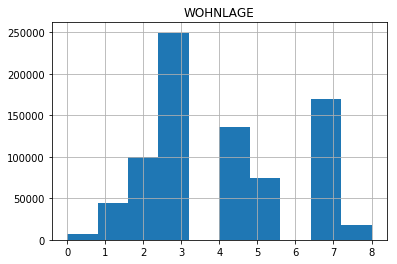

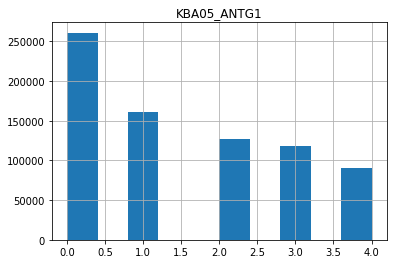

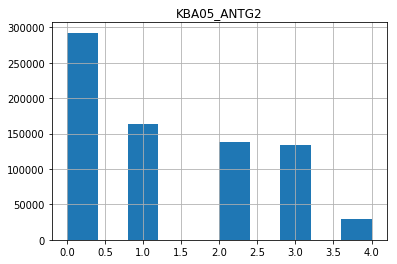

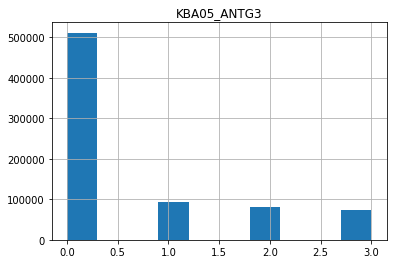

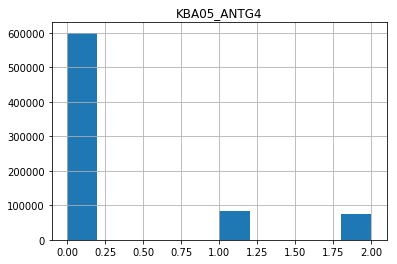

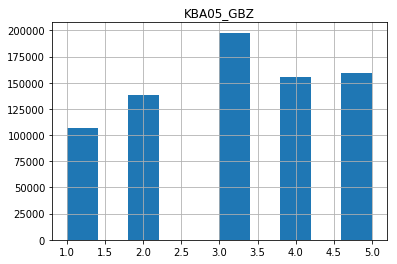

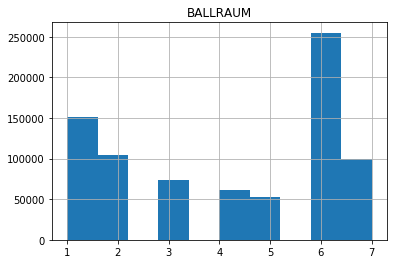

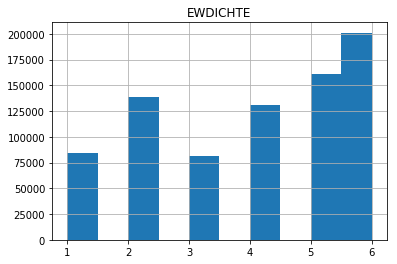

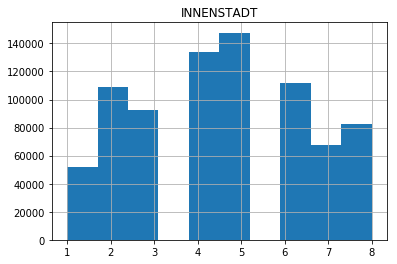

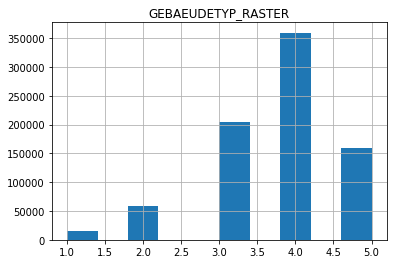

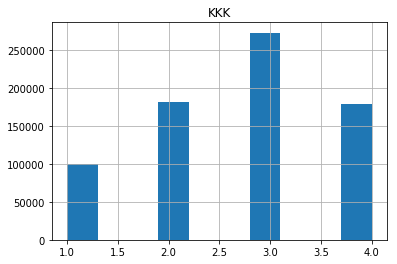

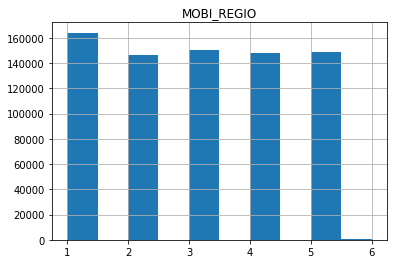

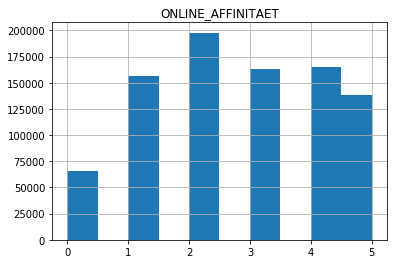

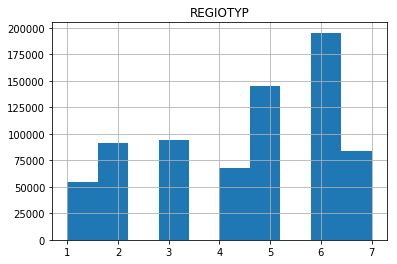

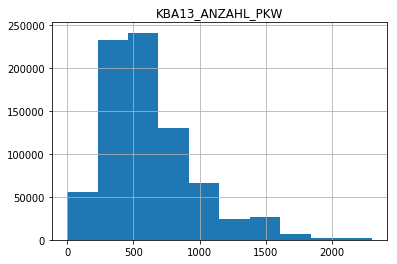

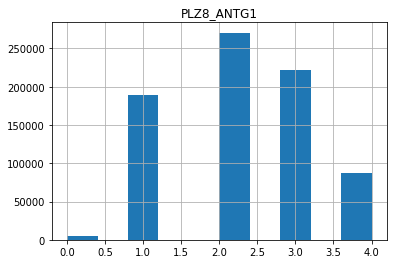

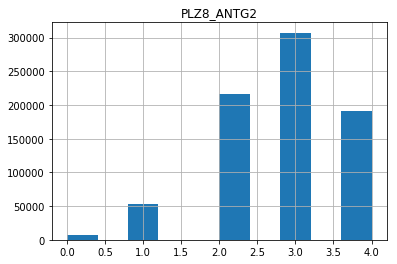

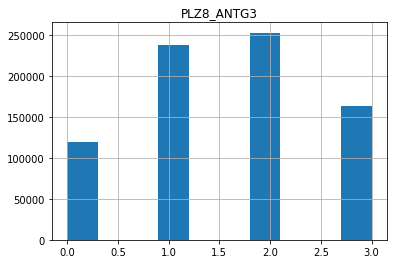

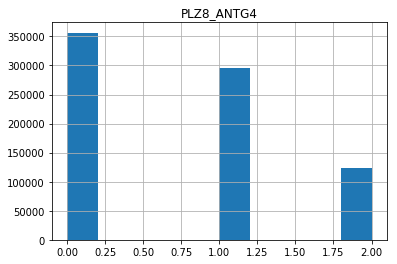

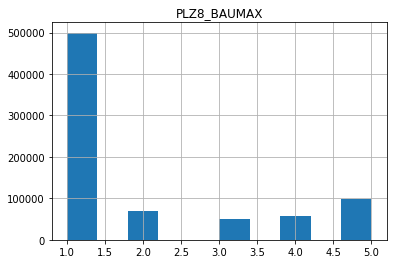

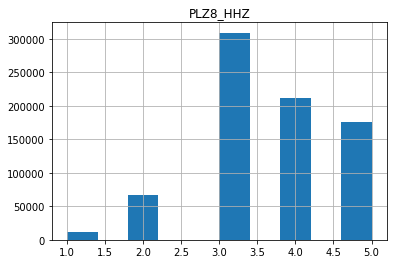

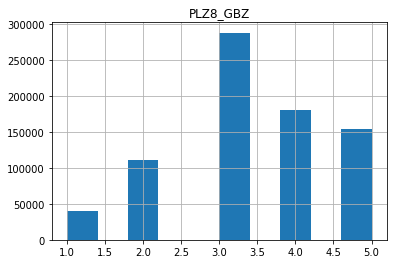

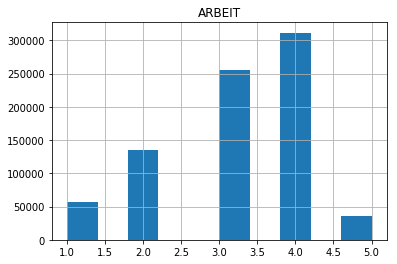

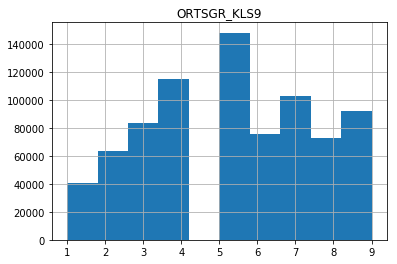

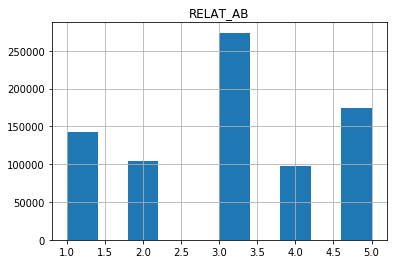

In [24]:
for attribute in azdias_nan:
    if azdias_nan[attribute].dtypes == float or azdias_nan[attribute].dtypes == int:
        null_val = azdias_nan[attribute].isnull().sum()
        total_val = 891221
        missing_percent = round((null_val / total_val) * 100 , 1)
    
    
        if missing_percent <= 25 and missing_percent != 0 :
            azdias_nan.hist(column= attribute)
            plt.show()



One of the most interesting is ALTER_HH. It looks like steps as the values start around 2 and keep increasing until after 20.

Some of the data types are object and won't work in the above function.  Some of the columns are stored as objects. These contain both numbers and had some letters as well. The data dictionary will be useful in finding out what these mean. Some were missing and already have been removed (X, XX)

In [25]:
for attribute in azdias_nan:
    if azdias_nan[attribute].dtype == object:
        print(attribute)

OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015


These columns all have numerical values as well as some other values like 'X'
The first two Cameo distributions are normal, positive skewed. Ost_West has only 0 or W.
The last Cameo has many different letters. 

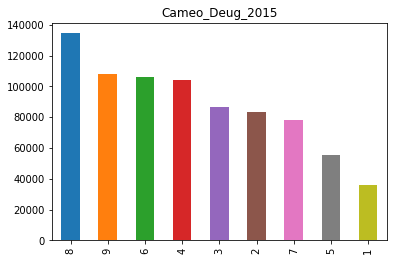

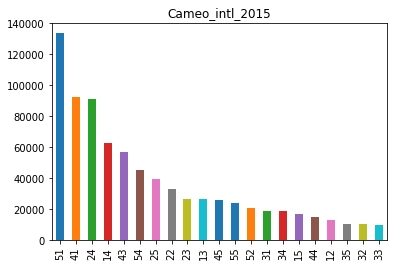

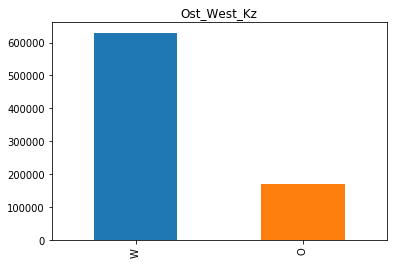

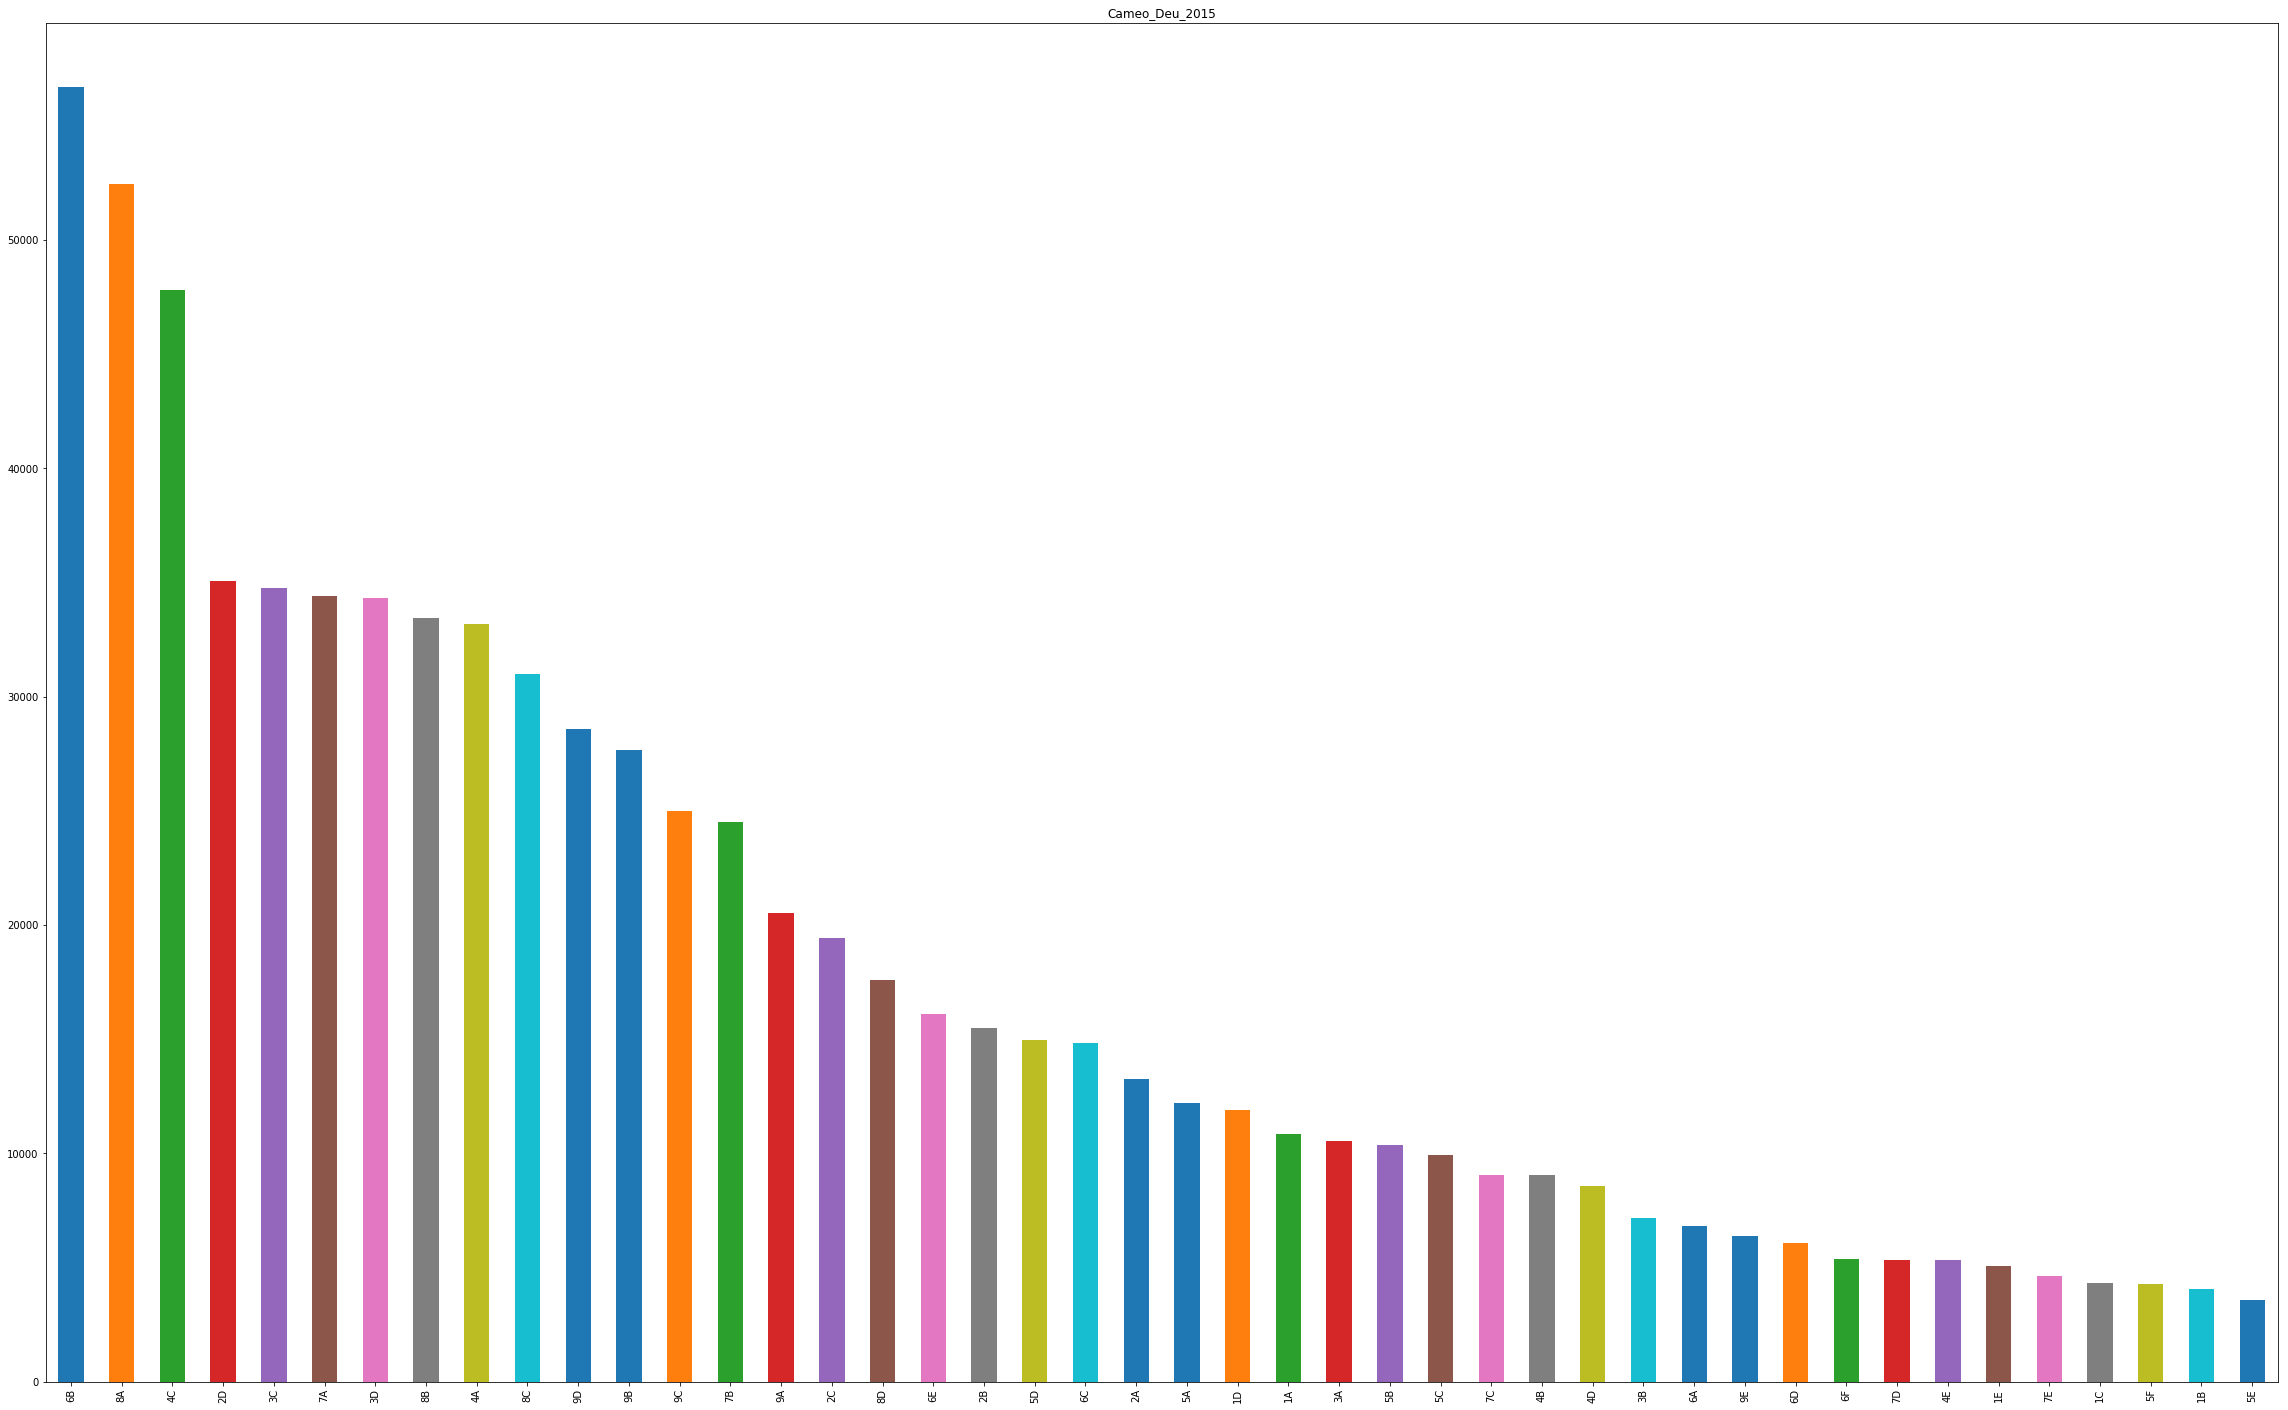

In [26]:
azdias_nan.CAMEO_DEUG_2015.value_counts().plot(kind= 'bar')
plt.title('Cameo_Deug_2015')
plt.show()
azdias_nan.CAMEO_INTL_2015.value_counts().plot(kind= 'bar')
plt.title('Cameo_intl_2015')
plt.show()
azdias_nan.OST_WEST_KZ.value_counts().plot(kind= 'bar')
plt.title('Ost_West_Kz')
plt.show()
azdias_nan.CAMEO_DEU_2015.value_counts().plot(kind= 'bar', figsize = (40,25))
plt.title('Cameo_Deu_2015')
plt.show()

In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#make another copy. Drop the columns, check the shape to confirm (80 columns)

azdias_clean = azdias_nan.copy()
azdias_clean.drop(columns=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','ALTER_HH'], inplace = True)

azdias_clean.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There were five columns that were missing 40% of more of the data. This is a large amount of data to be missing, so those were the columns that were dropped: Ager_typ, Geburtsjahr, titel_hz, KK_Kundentyp, KBA05_Baumax. There were 24 columns that actually were 100% complete. These may have had something to force the person to enter a value because nothing was missing. There were four columns that had categorical responses. These can be hot encoded, or have another transformation done to them if they seem to be useful. I will have to consult the data dictionary on those. Finally, in the remaining columns, there are some that are mostly made up of only one value. These columns may not be useful, but we will check the outliers before doing anything with them. The remaing columns that were not complete, nor removed had an average of a little over 10% missing. Five percent with this amount of data would probably not make much difference, but we may have to impute some of the values for these. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Missing Values in Rows:  5035304


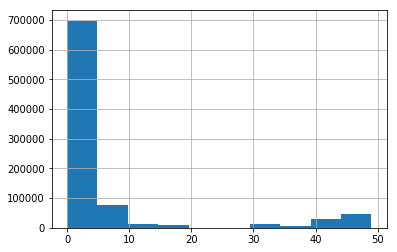

In [28]:
# How much data is missing in each row of the dataset?
NAN_Count_row = azdias_clean.isnull().sum(axis = 1)
print('Missing Values in Rows: ' , NAN_Count_row.sum())
azdias_clean['NAN_CNT'] = NAN_Count_row
NAN_Count_row.hist()
plt.show()

Luckily, most rows are missing 10 or less data values. I am most likely going to cut off anything with 15 or more missing values. 

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_large_missing = azdias_clean[azdias_clean['NAN_CNT'] > 15 ].copy()
azdias_small_missing = azdias_clean[azdias_clean['NAN_CNT'] <= 15].copy()






In [30]:
def cnt_plot(column_name):
    '''
    INPUT column name
    This function makes a plot to compare side by side charts between missing many and missing few data points.
    '''
    row = 1
    column = 2
    number = 1
    fig_dims = (4, 3)
    theme = 'ticks'
    
    plt.subplot(row, column, number)
    sns.set_style(theme)
    sns.countplot(column_name, data = azdias_large_missing)
    plt.xlabel(column_name) 
    plt.ylabel("Count")
    plt.title("Many Missing Records")
    
    plt.subplot(row, column, number + 1)
    sns.countplot(column_name, data = azdias_small_missing)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title( "Few Missing Records")
    
    sns.set(rc = {'figure.figsize':(10,4)})
    row = row + 1
    
    plt.show()

These graphs demonstrate that the data was split correctly into two subsets. One with records missing more than 15 values, the other with records missing less than 15 values. 

Text(0.5,1,'Records Missing Many Values')

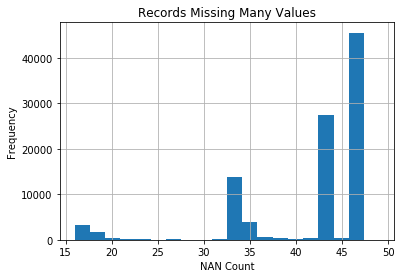

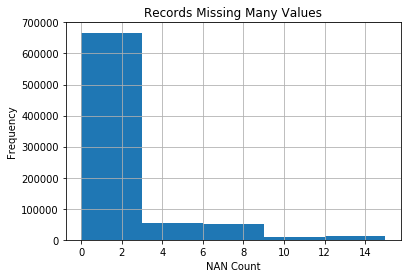

In [31]:
#Demonstrate that the data was split correctly.
azdias_large_missing.hist(column= 'NAN_CNT', bins = 20)
plt.xlabel("NAN Count")
plt.ylabel("Frequency")
plt.title("Records Missing Many Values")

azdias_small_missing.hist(column= 'NAN_CNT', bins = 5)
plt.xlabel("NAN Count")
plt.ylabel("Frequency")
plt.title("Records Missing Many Values")


Some of the tables do not look much different in distributions even when there are a lot of records missing. 
The OST_WEST_KZ column has the same distribution of data even when the data is missing a lot of columns.

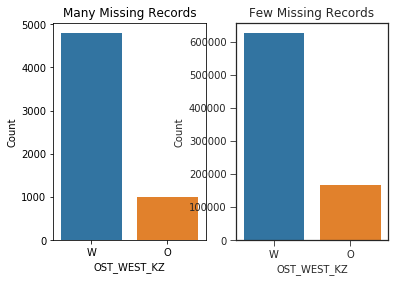

In [32]:
#Show the difference between the distribution. 
cnt_plot("OST_WEST_KZ")

These columns are not missing any data, but the distributions change a lot when we are missing many values.
When we are missing a lot of data, these columns have spikes in certain values, but on the more complete records, the distribution is actually much more even.
Removing these records that are missing more than 15 values will help us to get a much more accurate result once we apply 
the algorithyms.

['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']


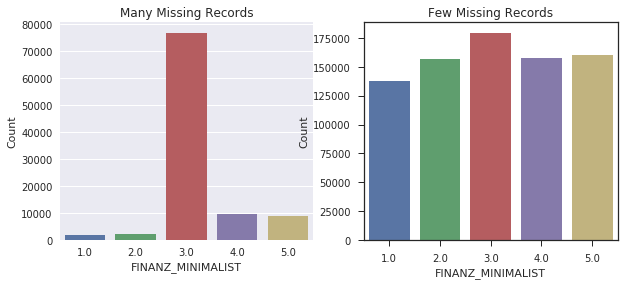

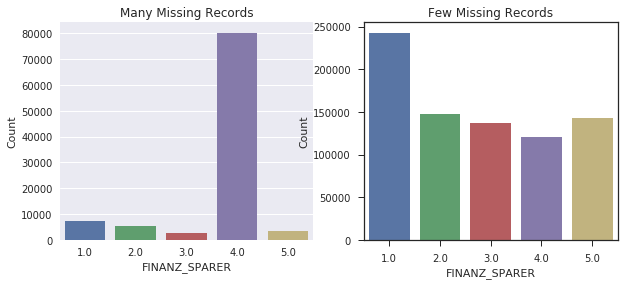

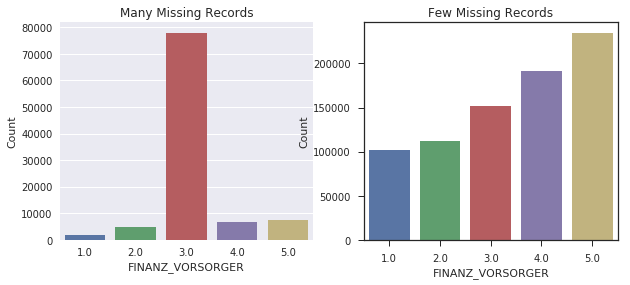

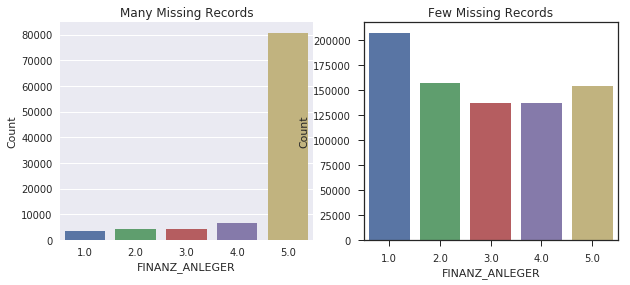

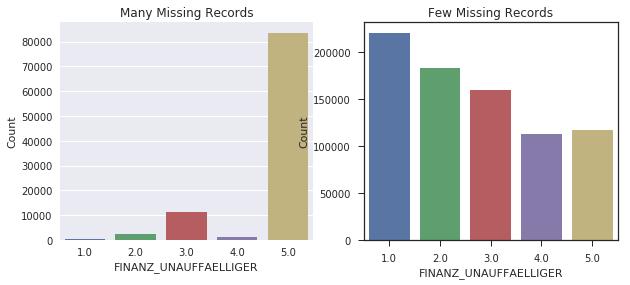

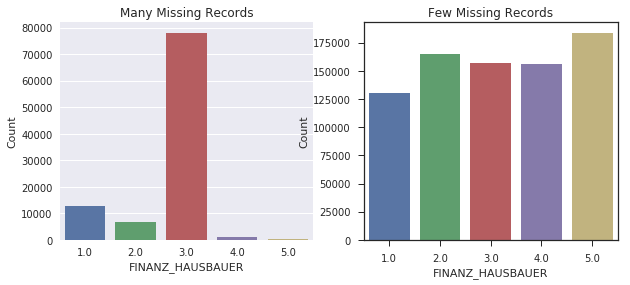

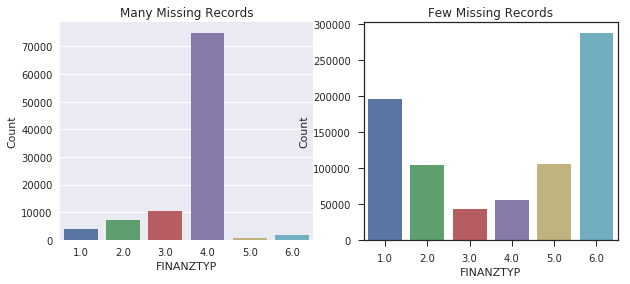

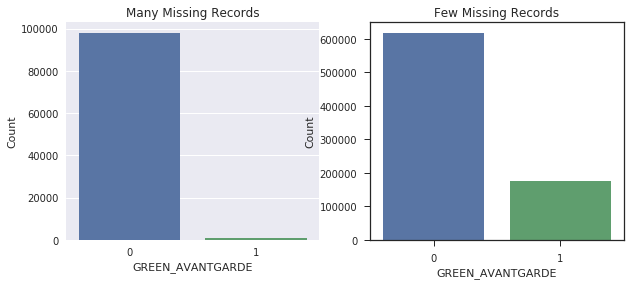

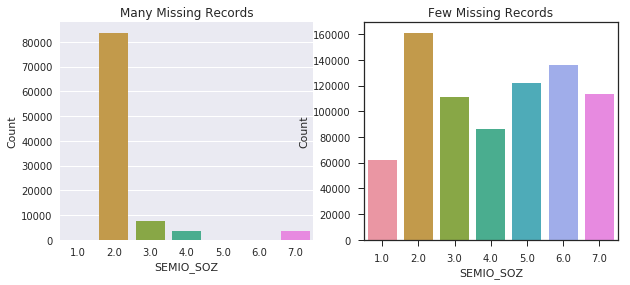

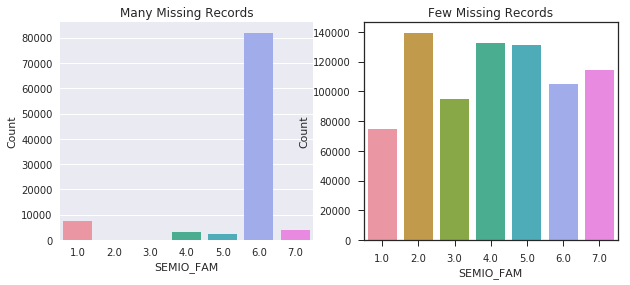

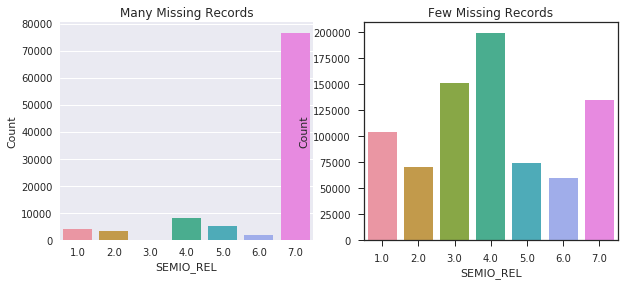

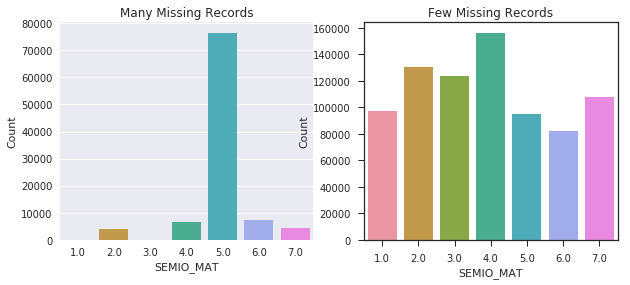

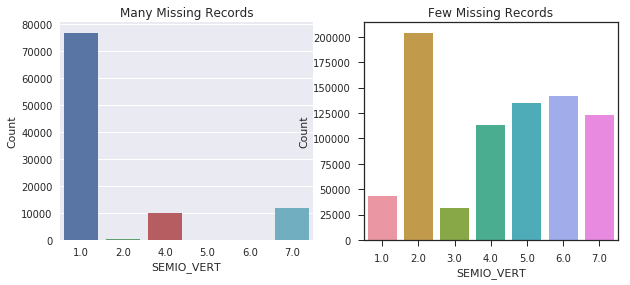

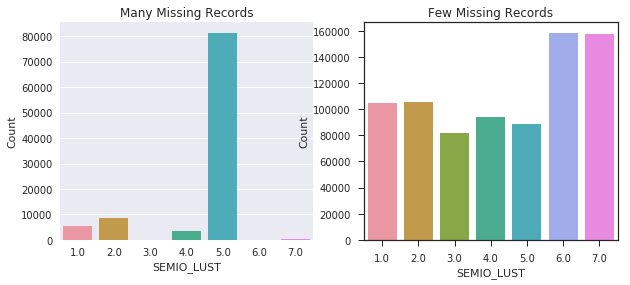

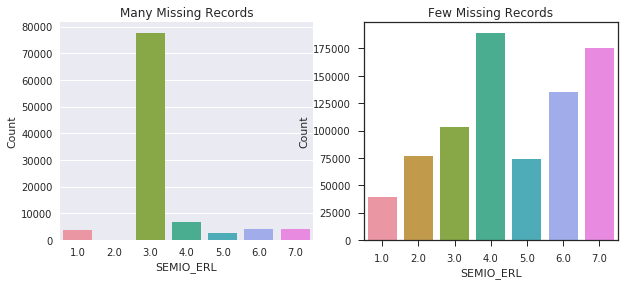

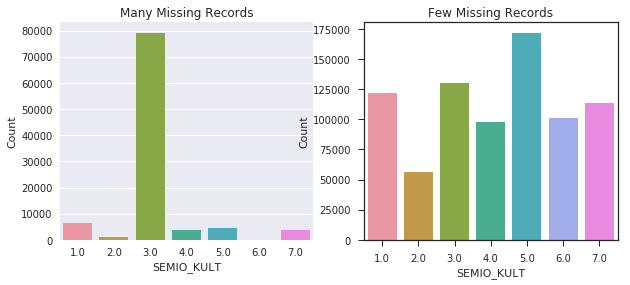

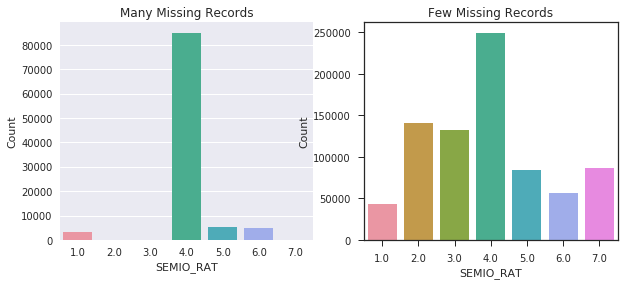

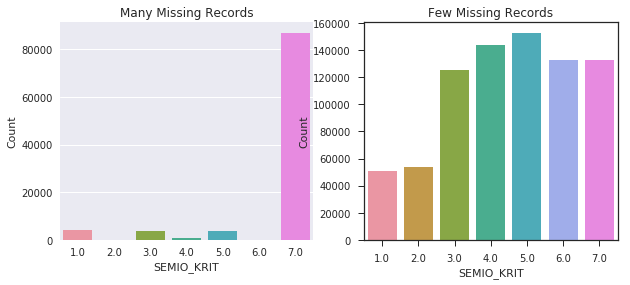

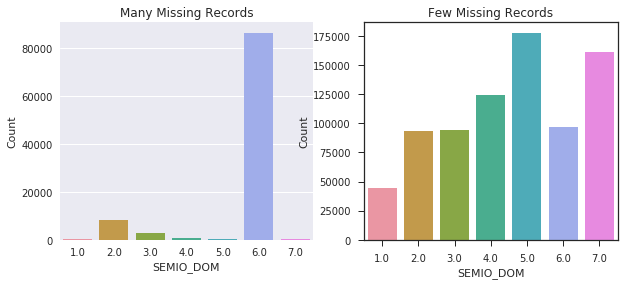

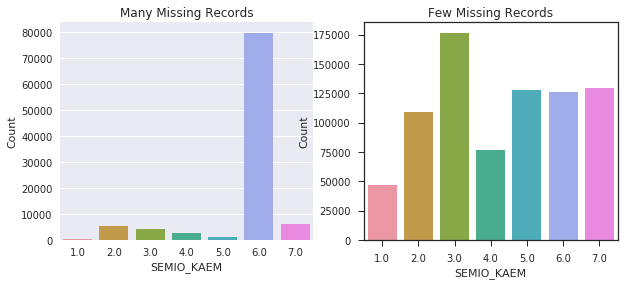

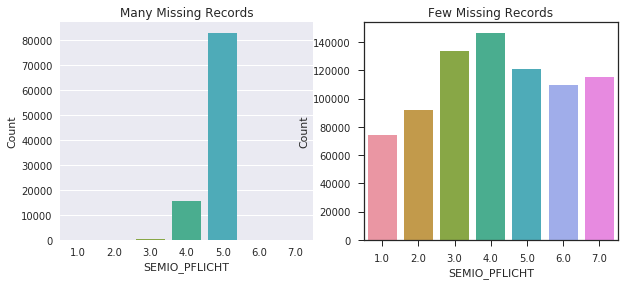

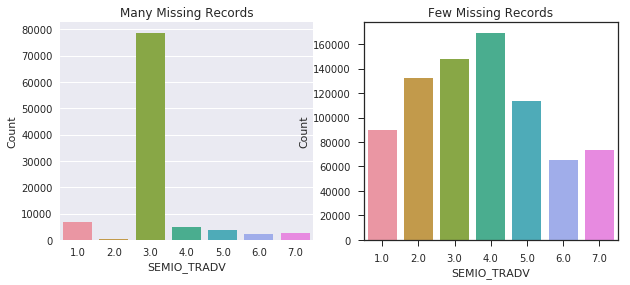

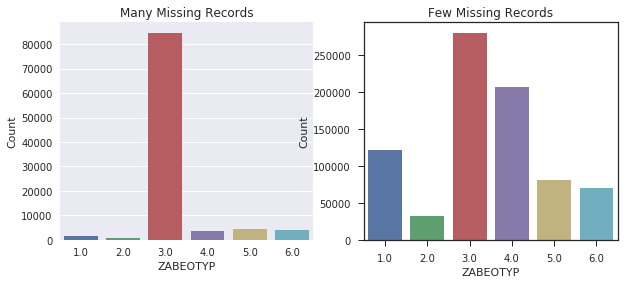

In [33]:
#Loop over the columns to run through the graph function. 
column_list = []
column_list = [
"FINANZ_MINIMALIST",
"FINANZ_SPARER",
"FINANZ_VORSORGER",
"FINANZ_ANLEGER",
"FINANZ_UNAUFFAELLIGER",
"FINANZ_HAUSBAUER",
"FINANZTYP",
"GREEN_AVANTGARDE",
"SEMIO_SOZ",
"SEMIO_FAM",
"SEMIO_REL",
"SEMIO_MAT",
"SEMIO_VERT",
"SEMIO_LUST",
"SEMIO_ERL",
"SEMIO_KULT",
"SEMIO_RAT",
"SEMIO_KRIT",
"SEMIO_DOM",
"SEMIO_KAEM",
"SEMIO_PFLICHT",
"SEMIO_TRADV",
"ZABEOTYP"]
print(column_list)

for col_name in column_list:
    cnt_plot(col_name)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The missing data rows are much different than the more complete rows. Looking at just the columns that start with Semio, we can see extreme differences in distributions. In the missing data records, there is a spike where one value tends to have all the numbers. In the more complete records, the values are much more evenly distributed. 

For example, SEMIO_VAT for the high missing record count has almost all the records in five, which means low affinity. We don't know what the low affinity / SEMIO_VAT means, but there could be a reason that the remaining columns were not filled out with that result. On SEMIO VERT, those records had a spike in highest affinity, but really the actual values are evenly distributed when low amounts of data is missing. 

Deleting these records will make the analysis more accurate, and will help the algorithm to work more accurately. However, it would be best to ask someone in the company more about these values to see why they are outliers apply some data governance best practices for future results. It could cause us to miss something important in regards to customer segmentation. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

Text(0.5,1,'Features Info')

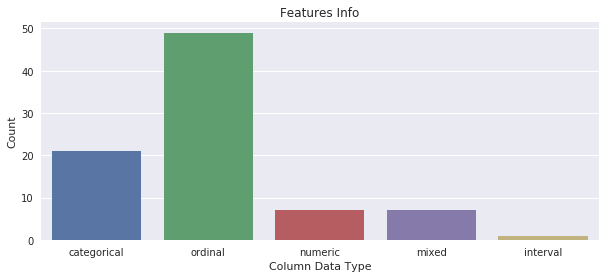

In [34]:
# How many features are there of each data type?

sns.countplot('type', data = feat_info)
plt.xlabel("Column Data Type")
plt.ylabel("Count")
plt.title("Features Info")



It looks like there will have to be a decision made on about 28 or so columns. The mixed and categorical will have to be
altered in order to be used. 

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [35]:
#Print the value counts and make a historgram
def count_the_value(column_name):
    print(azdias_small_missing[column_name].value_counts(dropna = False))
    
    if azdias_small_missing[column_name].dtype != object:
        azdias_small_missing.hist(column = column_name, bins= 10, figsize = (6, 2))
    plt.show()
                

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
count_attribs = 0
fix_me_list = []
count_fixes = 0

for attrib, val in zip(feat_info['attribute'], feat_info['type']):
    if (val == 'ordinal' or val == 'numeric' or val == 'interval'):
        count_attribs += 1
    if (val == 'categorical' or val == 'mixed'):
        
        if (attrib in azdias_small_missing) == True:
            fix_me_list.append(attrib)
            count_fixes += 1
print("Total Columns Ready:", count_attribs)
print("Total Columns to Fix", count_fixes)
print(fix_me_list)

        
    
    



Total Columns Ready: 57
Total Columns to Fix 24
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


This will sort the columns into binary and non-binary (and the one object that needs to be fixed).

In [37]:
#Make a list of columns that need to be fixed. Binary columns do not need to be fixed.
cleanup_list = []
 

for fix in fix_me_list:
    fix_len = (len(pd.unique(azdias_small_missing[fix])))
    
    #Some of the columns will need clean up for nan before they will be binary
    if (fix_len == 2 and azdias_small_missing[fix].dtype != object):
        print(fix, "is binary. No action needed")
    else:
        cleanup_list.append(fix)
      
print('Columns to Fix:', len(cleanup_list))


ANREDE_KZ is binary. No action needed
GREEN_AVANTGARDE is binary. No action needed
SOHO_KZ is binary. No action needed
Columns to Fix: 21


 4.0    196762
 3.0    146095
 2.0    140765
 5.0    110562
 6.0    101053
 1.0     92682
NaN       4368
Name: CJT_GESAMTTYP, dtype: int64


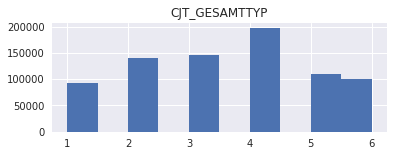

6.0    288550
1.0    195593
5.0    105764
2.0    103866
4.0     55652
3.0     42862
Name: FINANZTYP, dtype: int64


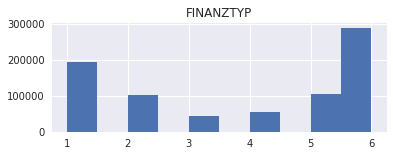

 12.0    128616
 10.0    102367
 8.0      82677
 11.0     74638
 5.0      70334
 4.0      60383
 9.0      56655
 3.0      53062
 1.0      50549
 2.0      42465
 7.0      40496
 6.0      25677
NaN        4368
Name: GFK_URLAUBERTYP, dtype: int64


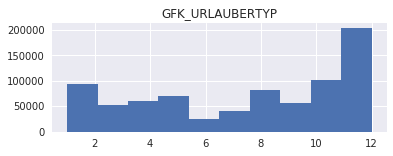

 1.0     58567
 5.0     52348
NaN      48801
 6.0     43199
 2.0     37070
 8.0     28761
 7.0     24920
 11.0    24910
 29.0    24813
 13.0    24759
 10.0    23935
 31.0    22233
 12.0    21896
 30.0    21060
 15.0    18931
 3.0     18654
 19.0    18358
 37.0    17382
 4.0     16454
 20.0    16259
 14.0    16250
 32.0    15733
 39.0    15111
 40.0    14104
 16.0    13579
 27.0    13567
 38.0    13001
 35.0    12938
 34.0    12298
 9.0     11992
 21.0    11938
 28.0    11474
 24.0    11270
 25.0     9756
 36.0     9630
 23.0     8491
 22.0     6802
 18.0     6547
 33.0     5709
 17.0     5440
 26.0     3347
Name: LP_LEBENSPHASE_FEIN, dtype: int64


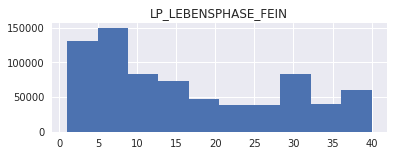

 2.0     149228
 1.0     130745
 3.0     108068
 12.0     69228
 4.0      50984
 5.0      46604
NaN       46001
 9.0      45873
 10.0     37966
 11.0     30945
 8.0      28388
 6.0      27231
 7.0      21026
Name: LP_LEBENSPHASE_GROB, dtype: int64


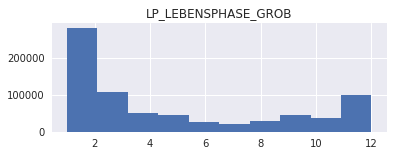

 1.0     399976
 10.0    128403
 2.0      97756
 11.0     48595
NaN       30511
 8.0      21675
 7.0      19406
 4.0      11505
 5.0      11128
 9.0      10401
 6.0       8333
 3.0       4598
Name: LP_FAMILIE_FEIN, dtype: int64


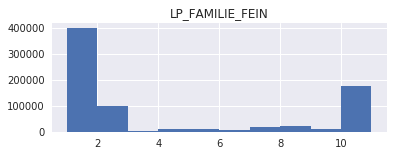

 1.0    399976
 5.0    187399
 2.0     97756
 4.0     49414
NaN      30511
 3.0     27231
Name: LP_FAMILIE_GROB, dtype: int64


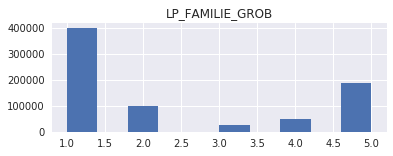

 1.0     206219
 9.0     134865
 10.0    111059
 2.0     110710
 4.0      73792
 3.0      68750
 6.0      28679
 5.0      27130
 8.0      17558
 7.0       9157
NaN        4368
Name: LP_STATUS_FEIN, dtype: int64


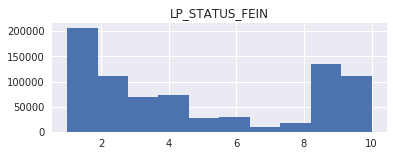

 1.0    316929
 2.0    169672
 4.0    152423
 5.0    111059
 3.0     37836
NaN       4368
Name: LP_STATUS_GROB, dtype: int64


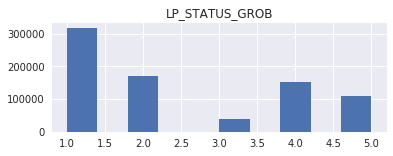

 1.0    663519
 2.0     63318
NaN      33115
 3.0     32335
Name: NATIONALITAET_KZ, dtype: int64


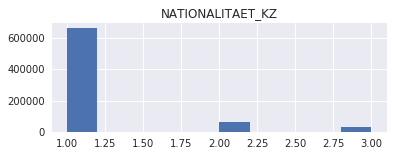

 14.0    181525
 8.0     140681
 10.0     85276
 5.0      84400
 3.0      53615
 15.0     42078
 11.0     35448
 9.0      33515
NaN       27615
 6.0      25629
 12.0     24340
 1.0      20550
 4.0      20431
 2.0       7470
 13.0      5714
 7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


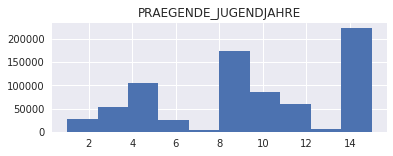

 1.0    245332
 2.0    205517
 3.0    178618
 0.0    126965
NaN      35855
Name: SHOPPER_TYP, dtype: int64


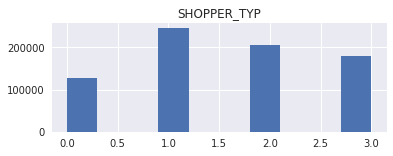

 2.0    393160
 1.0    363272
NaN      35855
Name: VERS_TYP, dtype: int64


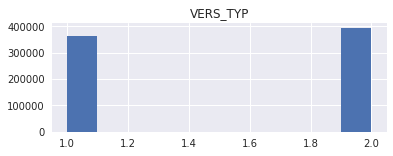

3.0    280232
4.0    206551
1.0    122157
5.0     80511
6.0     70585
2.0     32251
Name: ZABEOTYP, dtype: int64


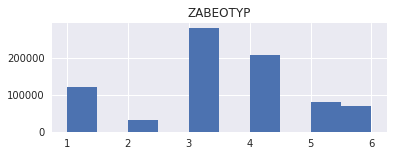

1.0    456167
3.0    177726
8.0    152213
2.0      4697
4.0       879
6.0       604
5.0         1
Name: GEBAEUDETYP, dtype: int64


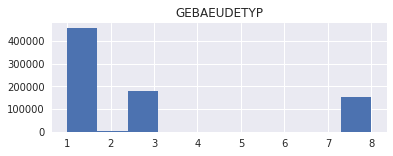

W    624737
O    167550
Name: OST_WEST_KZ, dtype: int64
3.0    248712
7.0    168756
4.0    135418
2.0     99983
5.0     73899
1.0     43720
8.0     16739
0.0      5060
Name: WOHNLAGE, dtype: int64


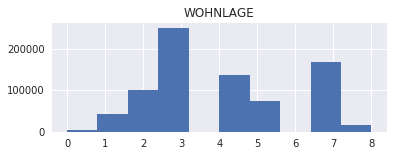

8      134183
9      107970
6      105538
4      103271
3       85800
2       82715
7       77676
5       54757
1       36061
NaN      4316
Name: CAMEO_DEUG_2015, dtype: int64
6B     56495
8A     52350
4C     47524
2D     34934
3C     34640
7A     34289
3D     34123
8B     33353
4A     32931
8C     30934
9D     28561
9B     27625
9C     24956
7B     24438
9A     20508
2C     19288
8D     17546
6E     16079
2B     15357
5D     14877
6C     14776
2A     13136
5A     11888
1D     11874
1A     10805
5B     10304
3A     10004
5C      9856
7C      9036
4B      8991
4D      8535
3B      7033
6A      6773
9E      6320
6D      6052
6F      5363
7D      5317
4E      5290
1E      5039
7E      4596
NaN     4316
1C      4287
5F      4264
1B      4056
5E      3568
Name: CAMEO_DEU_2015, dtype: int64
51     133492
41      92080
24      90699
14      62565
43      56495
54      45287
25      39413
22      32931
13      26162
45      26038
23      26028
55      23866
52      20508
31      18661
34      

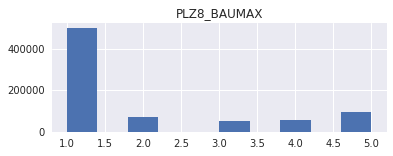

In [38]:
for cleanup in cleanup_list:
    count_the_value(cleanup)

In [39]:
#Some of the above will need special treatment. This will make a list of the ones that will get regular hot encoding.
#Verz Typ needs imputing before hot encoding.
azdias_hotEncode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',  'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',  'WOHNLAGE',  'CAMEO_DEUG_2015',  'PLZ8_BAUMAX']
print("Number of Columns to Hot Encode", len(azdias_hotEncode))
print("Number of records in dataframe:", len(azdias_small_missing))

Number of Columns to Hot Encode 17
Number of records in dataframe: 792287


 3.0    272616
 2.0    181162
 4.0    178416
 1.0     99727
NaN      60366
Name: KKK, dtype: int64


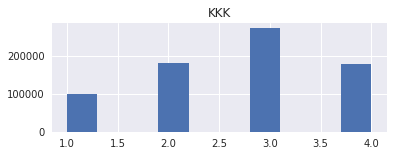

 6.0    195005
 5.0    145156
 3.0     93730
 2.0     91485
 7.0     83831
 4.0     68049
NaN      60366
 1.0     54665
Name: REGIOTYP, dtype: int64


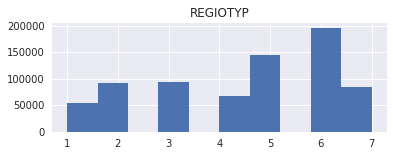

In [40]:
#Drop KKK #Drop REGIOTYP
count_the_value('KKK')
count_the_value('REGIOTYP')

The two columns above are still missing a lot of data once the records are removed. They are missing over 7%, or 59K in 
answers. I am going to drop those as well.


In [41]:
azdias_small_missing.drop(columns = ['KKK','REGIOTYP'], inplace = True)

In [42]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Make another copy of the dataframe:
final_azdias = azdias_small_missing.copy()

#First, change Ost_West_KZ to binary values. We will need to drop the original later.
final_azdias['OST_WEST_KZ_A'] = final_azdias.OST_WEST_KZ.map({'W': 1, 'O': 0})


'''
Looking up the values, this 6B is the most frequent and it stands for Petty Bourgeois (lower middle class)
Online it sounds like this would be the most common result for the country. There is only a small amount of wealthy,
The middle class is shrinking, and a lot lie beneath the poverty line. This will update the missing values 
to 6B, the most frequent value.
This is  one of a few articles on class:
http://www.xinhuanet.com/english/2019-08/12/c_138303931.htm
'''
final_azdias['CAMEO_DEU_2015'].fillna(value = '6B', inplace = True)

#update with the most frequent value
final_azdias['CAMEO_DEUG_2015'].fillna(value = 8, inplace  = True)
final_azdias['CAMEO_INTL_2015'].fillna(value = 51, inplace  = True)




In [43]:
# IF missing less than 5%, it will not be fixed. 
string_missing = []
int_missing = []
float_missing = []

for attribute in final_azdias:
    if final_azdias[attribute].dtypes != float or final_azdias[attribute].dtypes != int:
        null_val = final_azdias[attribute].isnull().sum()
        total_val = 791213
        missing_percent = round((null_val / total_val) * 100 , 1)
    
    
        if missing_percent > 5 :
            string_missing.append(attribute)
           
            
    if final_azdias[attribute].dtypes == float:
        null_val = final_azdias[attribute].isnull().sum()
        total_val = 791213
        missing_percent = round((null_val / total_val) * 100 , 1)
    
    
        if missing_percent > 5 :
            float_missing.append(attribute)
            

    if final_azdias[attribute].dtypes == int:
        null_val = final_azdias[attribute].isnull().sum()
        total_val = 791213
        missing_percent = round((null_val / total_val) * 100 , 1)
    
    
        if missing_percent > 5 :
            int_missing.append(attribute)
            

In [44]:
#Find the mean and fill in the nan with it.
for attribute in float_missing:
    my_mean = round(np.mean(final_azdias[attribute]),0) + 0.0
    final_azdias[attribute].fillna(value = my_mean, inplace = True)
    

In [45]:
#Update with the mean
for attribute in int_missing:
    my_mean = round(np.mean(final_azdias[attribute]),0)
    final_azdias[attribute].fillna(value = 51, inplace  = True)

In [46]:
#Update with the mean
for attribute in string_missing:
    my_mean = round(np.mean(final_azdias[attribute]),0) + 0.0
    final_azdias[attribute].fillna(value = my_mean, inplace = True)

In [47]:
pd.get_dummies(final_azdias, columns = azdias_hotEncode, drop_first = True)
print("Final Shape After Hot Encoding: " , final_azdias.shape)



Final Shape After Hot Encoding:  (792287, 79)


In [48]:
#Check again for NANs
final_azdias.isnull().sum()

ALTERSKATEGORIE_GROB      2740
ANREDE_KZ                    0
CJT_GESAMTTYP             4368
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP           4368
GREEN_AVANTGARDE             0
HEALTH_TYP               35855
LP_LEBENSPHASE_FEIN          0
LP_LEBENSPHASE_GROB          0
LP_FAMILIE_FEIN          30511
LP_FAMILIE_GROB          30511
LP_STATUS_FEIN            4368
LP_STATUS_GROB            4368
NATIONALITAET_KZ         33115
PRAEGENDE_JUGENDJAHRE    27615
RETOURTYP_BK_S            4368
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
                         ...  
MIN_GEBAEUDEJAHR             0
OST_WEST

#### Discussion 1.2.1: Re-Encode Categorical Features
Because it shouldn't matter if we move forward with columns missing 5% of the data, I left most of these alone. I dropped the KKK and the REGIOTYP columns because they were still missing over 7% even with all the rows that were dropped. I originally ran at 40% which is a lot of missing data, but I intended to cut more at this step. I also imputed the most frequent data in the class Cameo_DEU_2015 , and mapped the OZ KZ to 0 , 1 since it was binary but categorical. Then I hot encoded the rest. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#Mainstream = 1 , Avantgarde = 0
#East = 0 , west = 1, both = 2
final_azdias['PRAEGENDE_MAP'] = final_azdias.PRAEGENDE_JUGENDJAHRE.map({
    1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7:0, 8: 1, 9 : 0, 10: 1, 11 : 0 , 12:1, 13 : 0,  14:1 , 15: 0 })

final_azdias['JUGENDJAHRE_MAP'] = final_azdias.PRAEGENDE_JUGENDJAHRE.map({
     1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7:0, 8: 2, 9 : 2, 10: 1, 11 : 1 , 12:0, 13 : 0,  14:2 , 15: 2 
})
'''
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''


"\nDominating movement of person's youth (avantgarde vs. mainstream; east vs. west)\n- -1: unknown\n-  0: unknown\n-  1: 40s - war years (Mainstream, E+W)\n-  2: 40s - reconstruction years (Avantgarde, E+W)\n-  3: 50s - economic miracle (Mainstream, E+W)\n-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)\n-  5: 60s - economic miracle (Mainstream, E+W)\n-  6: 60s - generation 68 / student protestors (Avantgarde, W)\n-  7: 60s - opponents to the building of the Wall (Avantgarde, E)\n-  8: 70s - family orientation (Mainstream, E+W)\n-  9: 70s - peace movement (Avantgarde, E+W)\n- 10: 80s - Generation Golf (Mainstream, W)\n- 11: 80s - ecological awareness (Avantgarde, W)\n- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)\n- 13: 80s - Swords into ploughshares (Avantgarde, E)\n- 14: 90s - digital media kids (Mainstream, E+W)\n- 15: 90s - ecological awareness (Avantgarde, E+W)\n"

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

final_azdias = final_azdias.astype({"CAMEO_INTL_2015": int})

final_azdias['REICHTUM'] = final_azdias['CAMEO_INTL_2015'] // 10
final_azdias['FAMILIE']  = final_azdias['CAMEO_INTL_2015'] % 10

'''
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
'''


'\n- 11: Wealthy Households - Pre-Family Couples & Singles\n- 12: Wealthy Households - Young Couples With Children\n- 13: Wealthy Households - Families With School Age Children\n- 14: Wealthy Households - Older Families &  Mature Couples\n- 15: Wealthy Households - Elders In Retirement\n- 21: Prosperous Households - Pre-Family Couples & Singles\n- 22: Prosperous Households - Young Couples With Children\n- 23: Prosperous Households - Families With School Age Children\n- 24: Prosperous Households - Older Families & Mature Couples\n- 25: Prosperous Households - Elders In Retirement\n- 31: Comfortable Households - Pre-Family Couples & Singles\n- 32: Comfortable Households - Young Couples With Children\n- 33: Comfortable Households - Families With School Age Children\n- 34: Comfortable Households - Older Families & Mature Couples\n- 35: Comfortable Households - Elders In Retirement\n- 41: Less Affluent Households - Pre-Family Couples & Singles\n- 42: Less Affluent Households - Young Couples

In [51]:

final_azdias['CAMEO_DEU_2015_A'] = final_azdias.CAMEO_DEU_2015.map({    
'1B' : 2,
'1C' : 3,
'1D' : 4,
'1E' : 5,
'2A' : 6,
'2B' : 7,
'2C' : 8,
'2D' : 9,
'3A' : 10,
'3B' : 11,
'3C' : 12,
'3D' : 13,
'4A' : 14,
'4B' : 15,
'4C' : 16,
'4D' : 17,
'4E' : 18,
'5A' : 19,
'5B' : 20,
'5C' : 21,
'5D' : 22,
'5E' : 23,
'5F' : 24,
'6A' : 25,
'6B' : 26,
'6C' : 27,
'6D' : 28,
'6E' : 29,
'6F' : 30,
'7A' : 31,
'7B' : 32,
'7C' : 33,
'7D' : 34,
'7E' : 35,
'8A' : 36,
'8B' : 37,
'8C' : 38,
'8D' : 39,
'9A' : 40,
'9B' : 41,
'9C' : 42,
'9D' : 43,
'9E' : 44
})
'''
 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown
'''

'\n 1A: Work-Life-Balance\n- 1B: Wealthy Best Ager\n- 1C: Successful Songwriter\n- 1D: Old Nobility\n- 1E: City Nobility\n- 2A: Cottage Chic\n- 2B: Noble Jogger\n- 2C: Established gourmet\n- 2D: Fine Management\n- 3A: Career & Family\n- 3B: Powershopping Families\n- 3C: Rural Neighborhood\n- 3D: Secure Retirement\n- 4A: Family Starter\n- 4B: Family Life\n- 4C: String Trimmer\n- 4D: Empty Nest\n- 4E: Golden Ager\n- 5A: Younger Employees\n- 5B: Suddenly Family\n- 5C: Family First\n- 5D: Stock Market Junkies\n- 5E: Coffee Rider\n- 5F: Active Retirement\n- 6A: Jobstarter\n- 6B: Petty Bourgeois\n- 6C: Long-established\n- 6D: Sportgardener\n- 6E: Urban Parents\n- 6F: Frugal Aging\n- 7A: Journeymen\n- 7B: Mantaplatte\n- 7C: Factory Worker\n- 7D: Rear Window\n- 7E: Interested Retirees\n- 8A: Multi-culteral\n- 8B: Young & Mobile\n- 8C: Prefab\n- 8D: Town Seniors\n- 9A: First Shared Apartment\n- 9B: Temporary Workers\n- 9C: Afternoon Talk Show\n- 9D: Mini-Jobber\n- 9E: Socking Away\n- XX: unknow

#### Discussion 1.2.2: Engineer Mixed-Type Features
In additon to the two that were supplied, I also altered the CAMEO_DEU_2015. I didn't see any correlation between numbers 
or letters, so my first instinct was to split them into two columns but I didn't see any value in that. Instead I just changed them to numbers. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [52]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
#Dropping the original columns that were engineered. Dropping the east/ west. 

final_azdias.drop(columns = ['CAMEO_INTL_2015','JUGENDJAHRE_MAP','PRAEGENDE_JUGENDJAHRE','CAMEO_DEU_2015','OST_WEST_KZ'], inplace = True)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.
 $$$$$$

In [85]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    $$$$$
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_new = df.copy()
    
    
   
    for attribute, missing_vals in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    
        for value in missing_vals:
            if value != '' and (value.isnumeric() == True or value.lstrip('-').isdigit()):
                int_value = int(value)
                df_new.loc[df_new[attribute] == int_value, attribute ] = np.nan
            elif value != '' :
                df_new.loc[df_new[attribute] == value, attribute ] = np.nan
    
    print("Original Shape", df_new.shape)
    
    # remove selected columns and rows, ...
    print("Drop these Columns:")
    df_new.drop(columns=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','KKK','REGIOTYP','ALTER_HH'], inplace = True)
    
    for attribute in df_new:
        null_val = df_new[attribute].isnull().sum()
        total_val = df_new.shape[0]
        missing_percent = round((null_val / total_val) * 100 , 1)
   
        if missing_percent > 30:
            print(attribute, "Missing: {} %".format(missing_percent))
            #All like columns should have been dropped. This will tell us if more data is missing, but it will be interpolated.
            #df_new.drop(columns = [attribute], inplace = True)
    
    print("New Shape After Column Drop:", df_new.shape)
    
    NAN_Count_row = df_new.isnull().sum(axis = 1)
    print('Missing Values in Rows: ' , NAN_Count_row.sum())
    df_new['NAN_CNT'] = NAN_Count_row
    NAN_Count_row.hist()
    plt.title('Missing Values in Records')
    plt.show()
    
   
    
    
    df_clean = df_new[df_new['NAN_CNT'] <= 15].copy()
    
    print("New Shape After Row Drop:", df_clean.shape)
    
    # select, re-encode, and engineer column values.
    # IF missing less than 5%, it will not be fixed. 
    
    
    df_clean['CAMEO_DEU_2015'].fillna(value = '6B', inplace = True)
    df_clean['OST_WEST_KZ_A'] = df_clean.OST_WEST_KZ.map({'W': 1, 'O': 0})
    df_clean.drop(columns = ['OST_WEST_KZ'], inplace = True)
    
    missing = []
  
    
    for attribute in df_clean:

        null_val = df_clean[attribute].isnull().sum()
        total_val = df_clean.shape[0]
        missing_percent = round((null_val / total_val) * 100 , 1)
        
    
        if missing_percent > 5 :
            missing.append(attribute)
                

            my_mean = round(np.mean(df_clean[attribute]),0) + 0.0
            df_clean[attribute].fillna(value = my_mean, inplace = True)
            
            
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # Once dropping the clean up to 25%, this was no longer needed. 
    #Mainstream = 1 , Avantgarde = 0
    #East = 0 , west = 1, both = 2
    df_clean['PRAEGENDE_MAP'] = df_clean.PRAEGENDE_JUGENDJAHRE.map({
    1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7:0, 8: 1, 9 : 0, 10: 1, 11 : 0 , 12:1, 13 : 0,  14:1 , 15: 0 })

    df_clean['JUGENDJAHRE_MAP'] = df_clean.PRAEGENDE_JUGENDJAHRE.map({
     1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7:0, 8: 2, 9 : 2, 10: 1, 11 : 1 , 12:0, 13 : 0,  14:2 , 15: 2})


            
    df_clean['CAMEO_DEU_2015_A'] = df_clean.CAMEO_DEU_2015.map({'1B' : 2,'1C' : 3,'1D' : 4,'1E' : 5,'2A' : 6,'2B' : 7,'2C' : 8,
     '2D' : 9,'3A' : 10,'3B' : 11,'3C' : 12,'3D' : 13,'4A' : 14,'4B' : 15,'4C' : 16,'4D' : 17,'4E' : 18,'5A' : 19,'5B' : 20,
     '5C' : 21,'5D' : 22,'5E' : 23,'5F' : 24,'6A' : 25,'6B' : 26,'6C' : 27,'6D' : 28,'6E' : 29,'6F' : 30,'7A' : 31,'7B' : 32,
     '7C' : 33,'7D' : 34,'7E' : 35,'8A' : 36,'8B' : 37,'8C' : 38,'8D' : 39,'9A' : 40,'9B' : 41,'9C' : 42,'9D' : 43,'9E' : 44})
            
    #update with the most frequent value
    df_clean['CAMEO_DEUG_2015'].fillna(value = 8, inplace  = True)
    df_clean['CAMEO_INTL_2015'].fillna(value = 51, inplace  = True)
          
                
    for column in df_clean.columns:
        df_clean[column] = df_clean[column].interpolate(limit_direction = 'both')
            

    

 
    
    # Return the cleaned dataframe.
    
    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [54]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
for column in final_azdias.columns:
    final_azdias[column] = final_azdias[column].interpolate(limit_direction = 'both')



In [55]:
#Check engineered column
print(final_azdias['CAMEO_DEU_2015_A'])

1         36.0
2         16.0
3          6.0
4         26.0
5         38.0
6         14.0
7          9.0
8          7.0
9          5.0
10        43.0
12        26.0
13        21.0
15        37.0
16        31.0
18        16.0
19        22.0
20        16.0
21        44.0
22        43.0
23        26.0
25        21.0
27        41.0
28        23.5
29         6.0
31        43.0
32         2.0
33        37.0
34        13.0
36        31.0
37        16.0
          ... 
891191    27.0
891192    20.0
891193    26.0
891194    16.0
891195    39.0
891196    15.0
891197    12.0
891198     8.0
891199    36.0
891200    40.0
891201    31.0
891202    37.0
891203    13.0
891204    12.0
891205    23.0
891206    13.0
891207    31.0
891208     8.0
891209    36.0
891210    37.0
891211    43.0
891212    43.0
891213    23.0
891214    10.0
891215    19.0
891216    31.0
891217    43.0
891218    16.0
891219    43.0
891220    26.0
Name: CAMEO_DEU_2015_A, Length: 792287, dtype: float64


In [56]:
#Hot encode the remaining columns after engineering.
pd.get_dummies(final_azdias, columns=['CAMEO_DEU_2015_A'], drop_first = True)
print(final_azdias.shape)

(792287, 79)


In [57]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
final_azdias[final_azdias.columns] = scaler.fit_transform(final_azdias[final_azdias.columns].as_matrix())




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Discussion 2.1: Apply Feature Scaling

Originally, the NANs were only replaced if it was missing over 5%, since under 5% generally shouldn't impact the results. In most cases, the mean was used. In others, the most frequent value was used. Now, the rest will be filled with interpolate. 
Interpolate will be used to fill in the missing values from both directions. 
The standard scaler sounds like a better choice for these columns instead of the min max. According to the article, the minmax is best used when we know the range. 
https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
def apply_PCA(ncomponents, dataframe):
    pca = PCA(ncomponents)
    newdf_PCA = pca.fit_transform(dataframe)
    print('PCA has been applied')
    return pca, newdf_PCA

In [59]:
ncomponents= final_azdias.shape[1]


pca, azdias_PCA = apply_PCA(ncomponents, final_azdias)

PCA has been applied


In [60]:
# Investigate the variance accounted for by each principal component.

def make_scree(pca, azdias_PCA):
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth = 1, color= 'green')
    plt.ylabel('Variance')
    plt.xlabel('Component')
    plt.title('Scree Plot')
    plt.show()
  
    


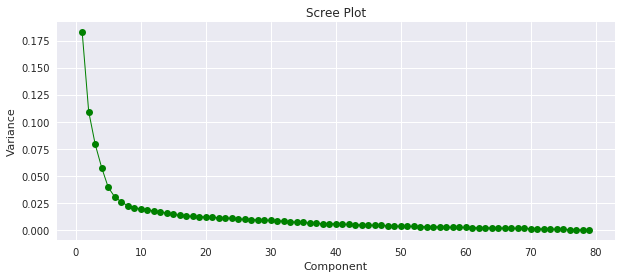

In [61]:
make_scree(pca, azdias_PCA)

Most of the impact is happening between 10 and 20. I will cut it off at 80%.

In [62]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, azdias_PCA = apply_PCA(26, final_azdias)

PCA has been applied


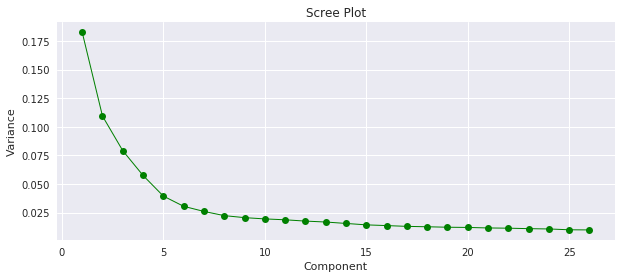

Total Variance:


80.0

In [63]:
#Make the screen plot to show the adjusted variance.
make_scree(pca, azdias_PCA)
variance = pca.explained_variance_ratio_

print("Total Variance:")
round(variance.sum() * 100,0) 


### Discussion 2.2: Perform Dimensionality Reduction

There will be 26 columns retained. That will cover 80% of the variance, and go to a little over the elbow in the scree 
chart. After 30 values, it drops off without much change so we can drop the rest of the columns without much consequence.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [64]:
def map_weight(dataframe, comp_number):
    
    
    comp_weight = pd.DataFrame(np.round(pca.components_ , 3), columns = dataframe.keys()).iloc[comp_number - 1 ]
    comp_weight.sort_values(ascending = False , inplace = True)

    top_comp = comp_weight.head(10)
    bottom_comp = comp_weight.tail(10)
    
    plt.subplot(1, 2, 1)
    
    top_comp.plot.bar()
    plt.ylabel('Variance')
    plt.title('PCA  {} Top 10'. format(comp_number))
 
    
    
    plt.subplot(1, 2, 2)
    
    bottom_comp.plot.bar()
    plt.ylabel('Variance')
    plt.title('PCA  {} Bottom 10 '. format(comp_number))
    
    plt.subplots_adjust(wspace = 0.5)
    plt.show()
    


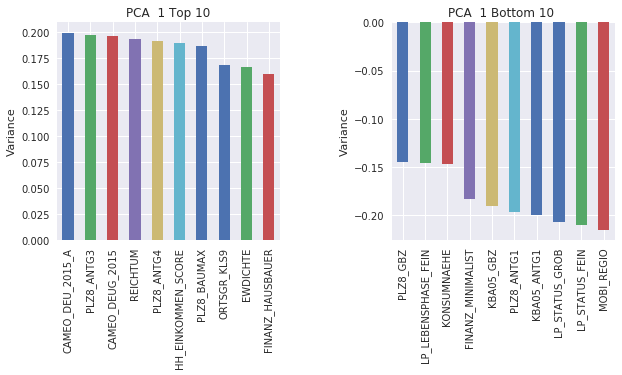

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
map_weight(final_azdias, 1)



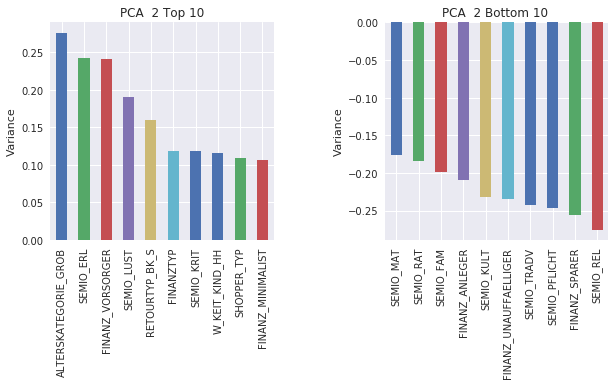

In [66]:
map_weight(final_azdias, 2)

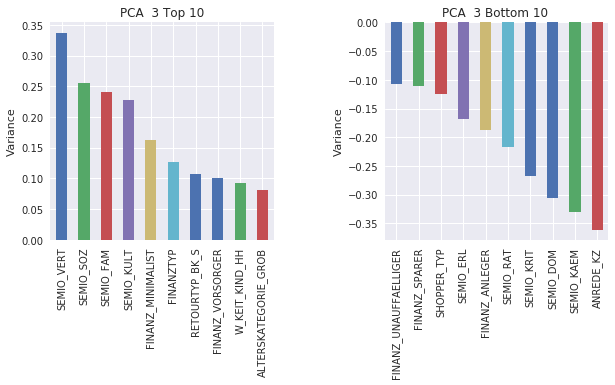

In [67]:
map_weight(final_azdias, 3)

### Discussion 2.3: Interpret Principal Components
It's hard to tell without being closer to the data and what it means exactly, but looking at the data dictionary and the top and bottom values, we can come to some conclusions about these principal components.
The first one seems to be based on wealth. There are stages of life, different measures of wealth, and houses in a region. At the opposite end, movement out of the regions is listed. 
The second set seems to be based on values and beliefs. Many of the columns listed outline idealogies that a person would believe in. 
The third set is personality based. At the top end, there are the emotional qualities of a person. At the bottom end are the more rational qualities of a person. This one is the most interesting to me because I would guess the emotional cluster could be swayed more by marketing techniques.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
# Over a number of different cluster counts...
def cust_clust(dataframe, clust_count):
    
    

    # run k-means clustering on the data and...
    k_means = KMeans(n_clusters = clust_count)
    model = k_means.fit(dataframe)
    
    # compute the average within-cluster distances.
    k_score = np.abs(model.score(dataframe))
    
    #labels = model.predict(dataframe)
    
    return k_score , model
    

    
    

In [69]:
all_scores = []
cen_list = []

start = time.time()

# To test, run with smaller range. This takes a long time to run.

#for c in range(1, 2):
for c in range(2,12):
    scores, model = cust_clust(azdias_PCA, c)
    all_scores.append(scores)
    cen_list.append(c)

end = time.time()

total_time_elapsed = (end - start) / 60

print("Time to run Cluster Check in Min: " ,total_time_elapsed)

Time to run Cluster Check in Min:  11.730436631043752


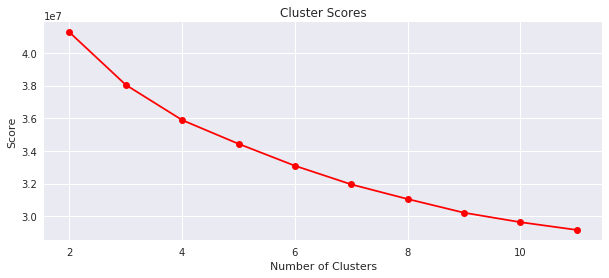

In [70]:
plt.plot(cen_list, all_scores, color = "red", marker = "o")
plt.title("Cluster Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.show()

There isn't much change after 8, so I will end this at 8 clusters. 

In [71]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
scores, model = cust_clust(azdias_PCA,8)
pred = model.predict(azdias_PCA)

### Discussion 3.1: Apply Clustering to General Population
The clusters seemed to not decrease much after 8, so in the model, 8 will be used going forward. The range 2, 12 was tested to make this decision. Although it might be better to increase the clusters closer to 12, it takes a long time to run, so with performance time as part of the calculation, 8 should suffice. Depending on the number of cores and CPU power of the person running this, they might decide to increase it, but it's not practical under current conditions.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [87]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [88]:
customers.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


Original Shape (191652, 85)
Drop these Columns:
New Shape After Column Drop: (191652, 77)
Missing Values in Rows:  2323469


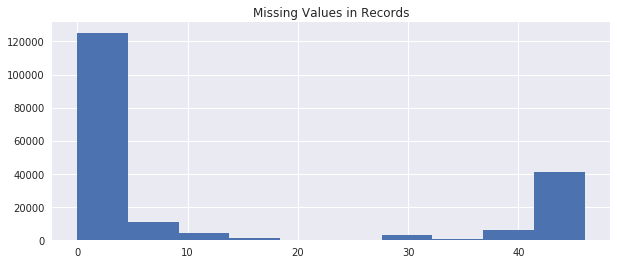

New Shape After Row Drop: (141221, 78)


In [89]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#$$$$$

cust_clean = clean_data(customers)


In [90]:
#Additional Engineering
    
cust_clean = cust_clean.astype({"CAMEO_INTL_2015": int})

cust_clean['REICHTUM'] = cust_clean['CAMEO_INTL_2015'] // 10
cust_clean['FAMILIE']  = cust_clean['CAMEO_INTL_2015'] % 10


In [91]:
#Drop engineered column originals
cust_clean.drop(columns = ['CAMEO_INTL_2015','JUGENDJAHRE_MAP','PRAEGENDE_JUGENDJAHRE','CAMEO_DEU_2015'], inplace = True)


In [92]:
#Hot encode
customer_clean = pd.get_dummies(cust_clean, drop_first = True)

In [93]:
#Check shape
print(cust_clean.shape)
cust_clean = pd.DataFrame(cust_clean)

(141221, 79)


In [94]:
#Check values to confirm
for attrib in cust_clean:
    print(cust_clean[attrib].value_counts())

4.0    83849
3.0    47237
2.0     5116
1.0     4908
3.5       94
2.5       17
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    94535
2.0    46686
Name: ANREDE_KZ, dtype: int64
2.000000    40885
4.000000    25390
3.000000    23379
1.000000    22707
5.000000    17191
6.000000    10183
3.500000      449
2.500000      400
1.500000      282
4.500000      176
5.500000       65
2.333333       13
2.666667       13
3.333333       13
3.666667       10
1.666667        9
4.666667        9
1.666667        7
1.333333        7
4.333333        7
3.333333        5
1.333333        4
2.666667        4
2.333333        4
5.333333        2
4.666667        2
2.250000        1
4.750000        1
4.250000        1
2.750000        1
3.666667        1
Name: CJT_GESAMTTYP, dtype: int64
5.0    81836
4.0    28193
3.0    19683
2.0     9795
1.0     1714
Name: FINANZ_MINIMALIST, dtype: int64
1.0    102700
2.0     23970
3.0      8799
4.0      3888
5.0      1864
Name: FINANZ_SPARER, dtype: int64
5.0    101651
4.0     2611

In [97]:
#Find missing columns 
missing_columns = set(final_azdias.columns) - set(cust_clean.columns)
for col in missing_columns:
    cust_clean[col] = 0

missing_2 = set(cust_clean.columns) - set(final_azdias.columns)
print(missing_columns)
    
# Ensure the order of column in the test set is in the same order than in train set
final_azdias = final_azdias[cust_clean.columns]

set()


In [98]:

cust_clean[cust_clean.columns] = scaler.transform(cust_clean[cust_clean.columns].as_matrix())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [99]:
### THis was updated due to error on first submission.
#pca, customers_PCA = apply_PCA(26, cust_clean)#


customers_PCA = pca.transform(cust_clean)



In [100]:

scores, model = cust_clust(customers_PCA,8)
pred_customers = model.predict(customers_PCA)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [101]:
#Make a data frame of the new predictions
gen_pred = pd.DataFrame(pred, columns = ['GENERAL_PREDICTION'])
cust_pred = pd.DataFrame(pred_customers, columns = ['CUSTOMER_PREDICTION'])


In [102]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


In [103]:
cust = []
gen = []


#The numbers start with 0 so add one.
x = [i + 1 for i in range(8)]

for i in range(8):
    cust.append((pred_customers == i).sum()/len(pred_customers))
    gen.append((pred == i).sum()/len(pred))

    
df_compare = pd.DataFrame({'cluster': x, 'general': gen, 'customer': cust })

                    
df_compare['Diff'] = (df_compare['general'] - df_compare['customer'])

print(df_compare)

   cluster   general  customer      Diff
0        1  0.135514  0.182784 -0.047270
1        2  0.142039  0.166243 -0.024204
2        3  0.107411  0.226439 -0.119029
3        4  0.118924  0.097202  0.021722
4        5  0.184311  0.107222  0.077089
5        6  0.142288  0.111322  0.030966
6        7  0.081435  0.019565  0.061870
7        8  0.088078  0.089222 -0.001144


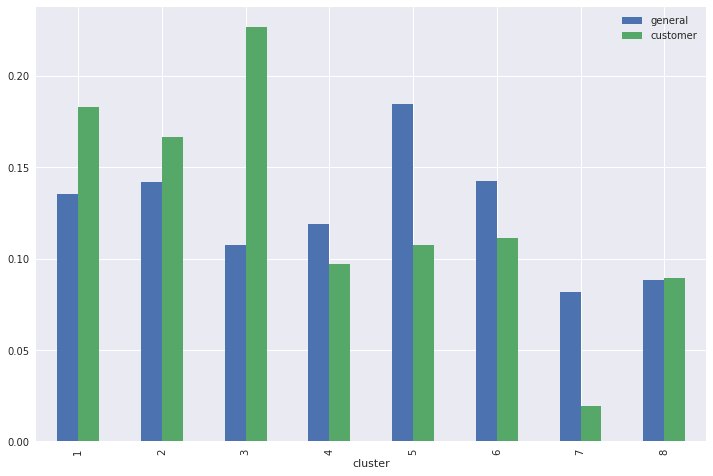

In [104]:
df_compare.plot(x = 'cluster', y = ['general', 'customer'] ,kind = 'bar', figsize = (12,8))
plt.show()

Clusters 3 and 4 are the most different between the two groups. 



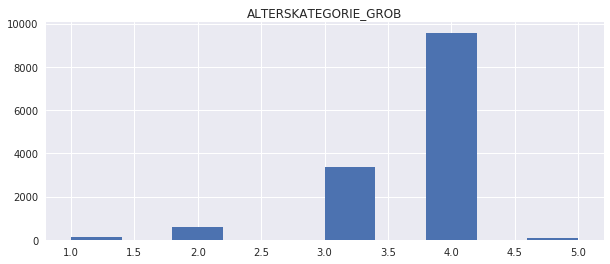

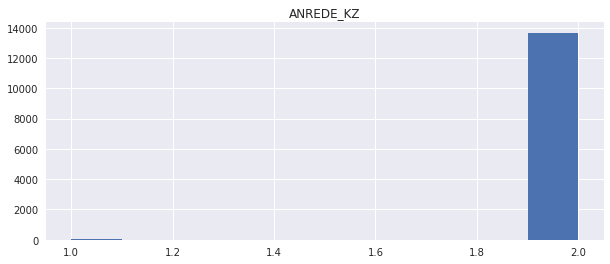

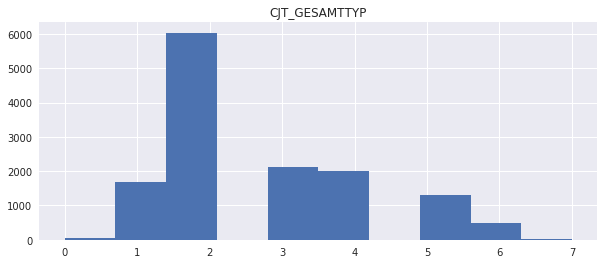

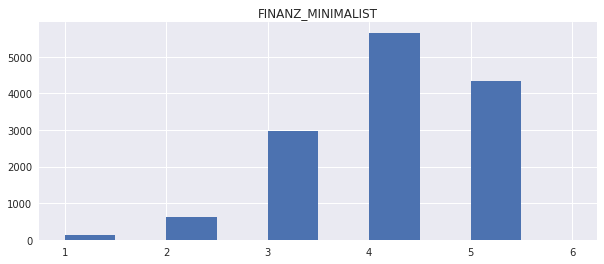

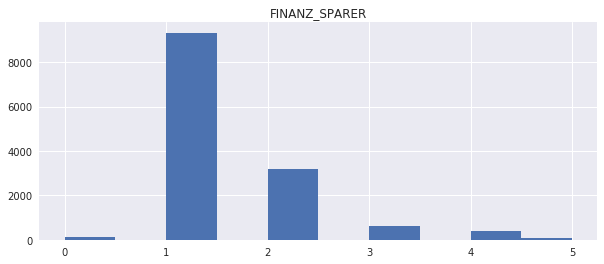

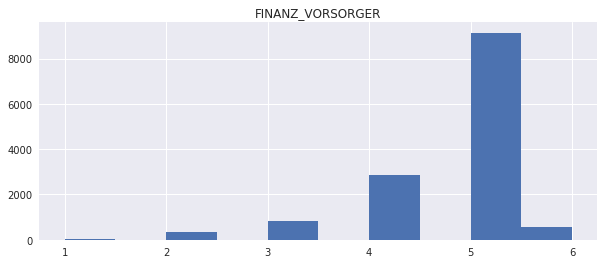

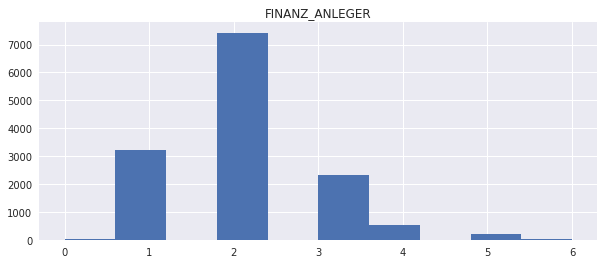

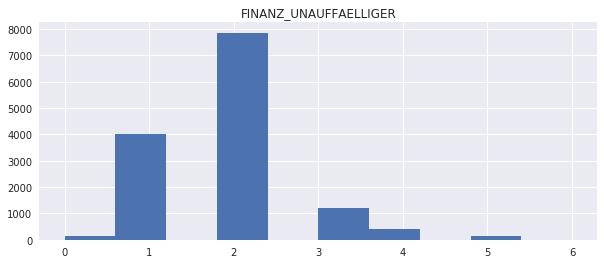

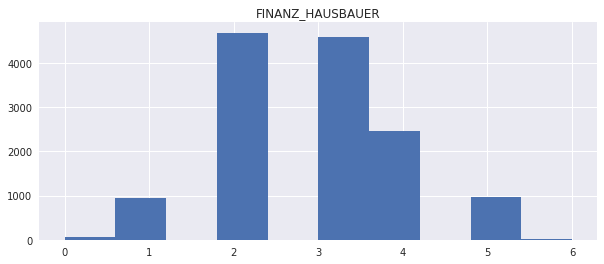

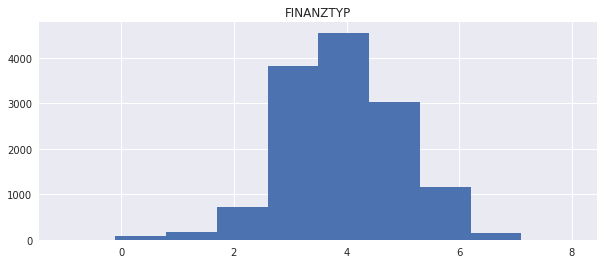

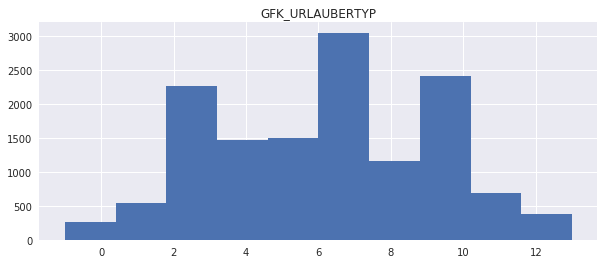

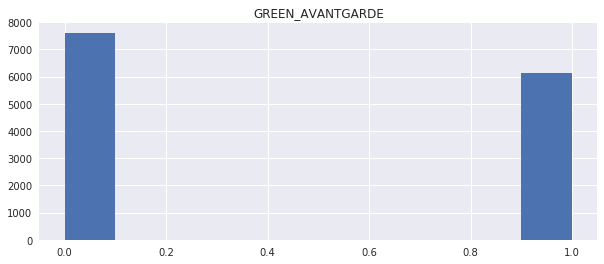

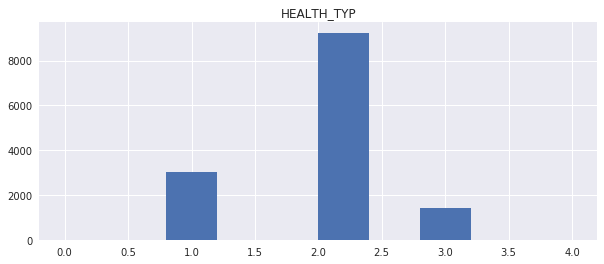

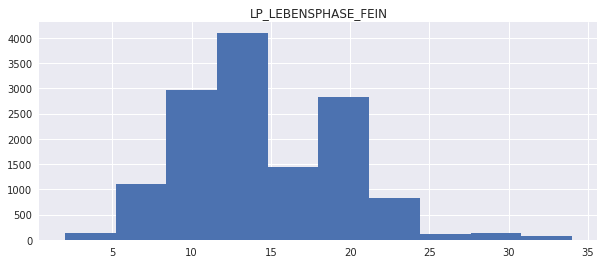

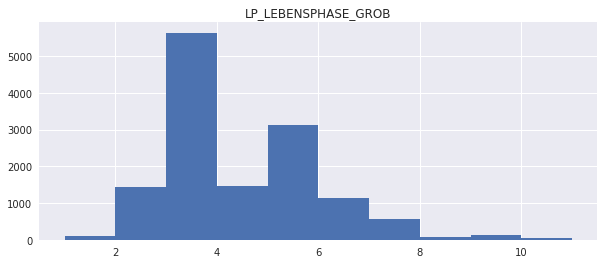

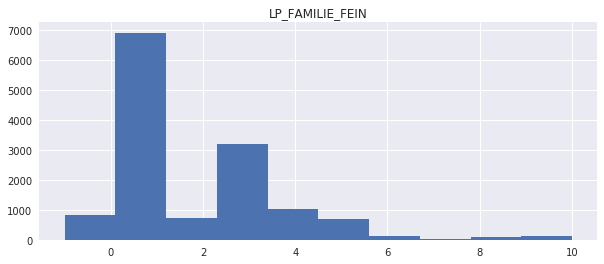

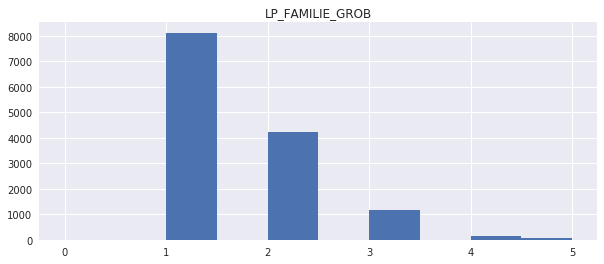

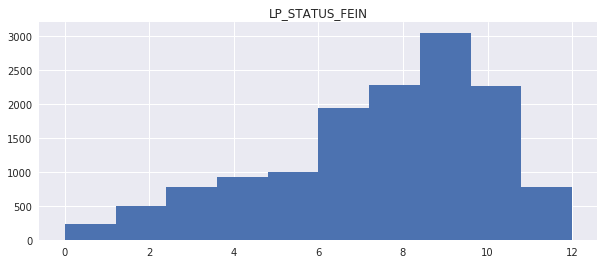

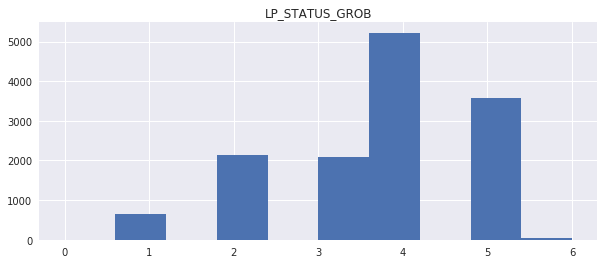

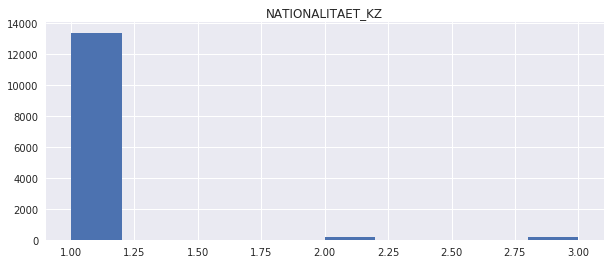

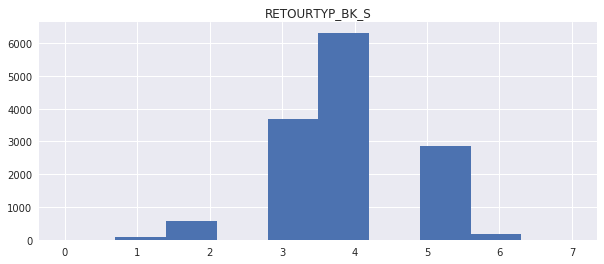

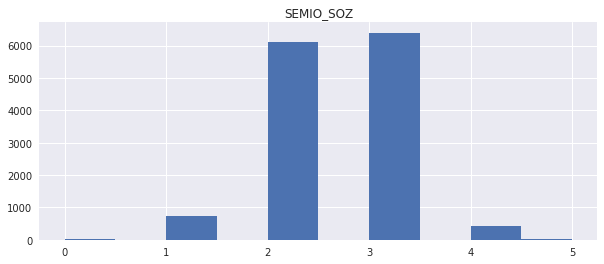

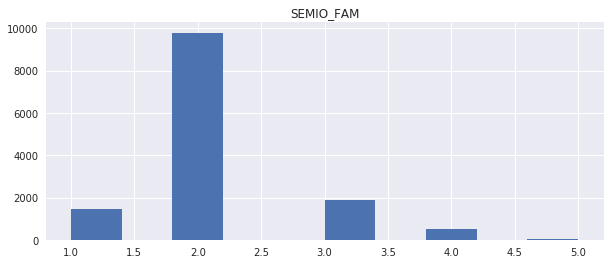

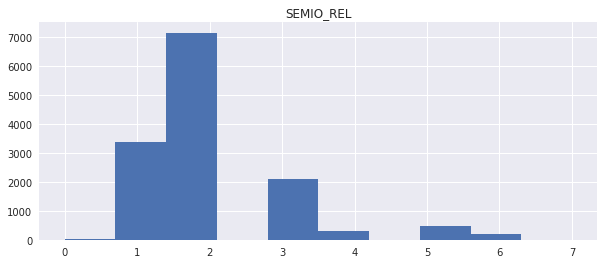

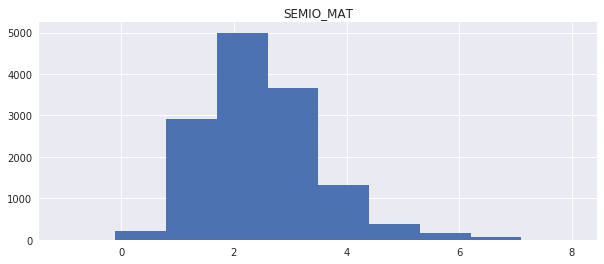

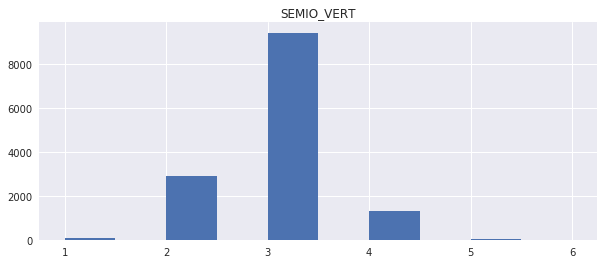

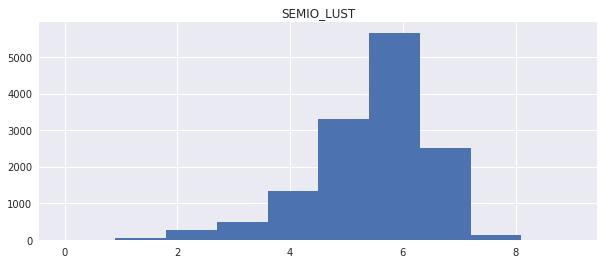

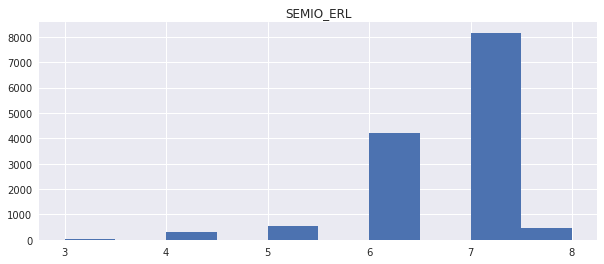

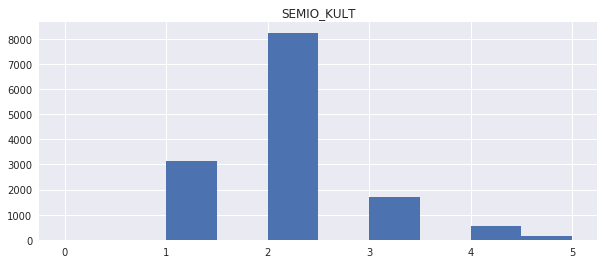

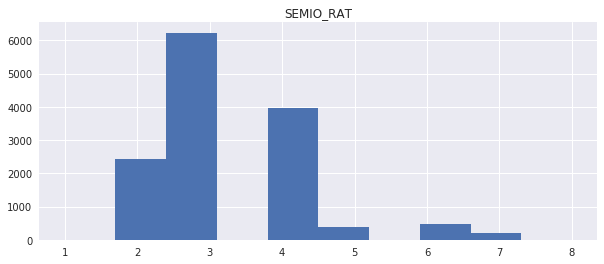

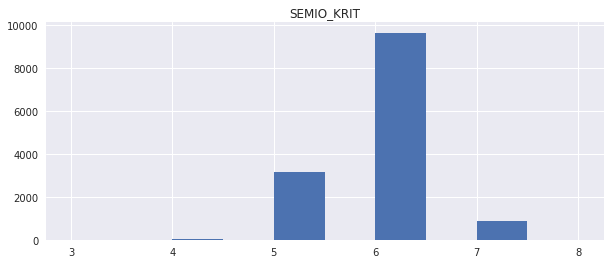

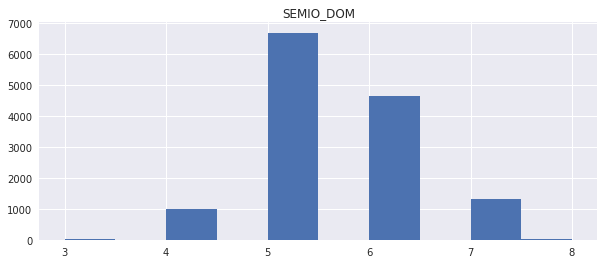

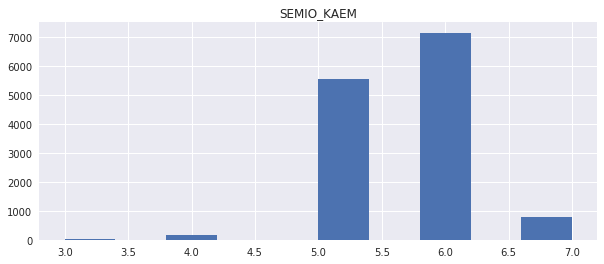

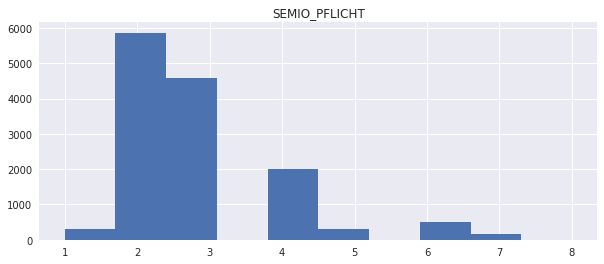

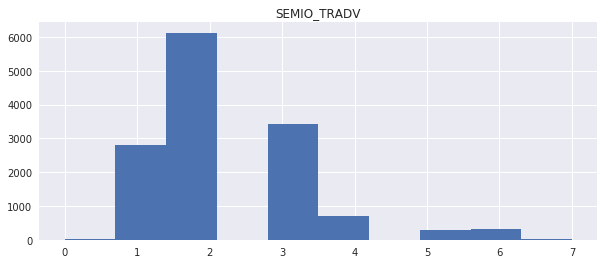

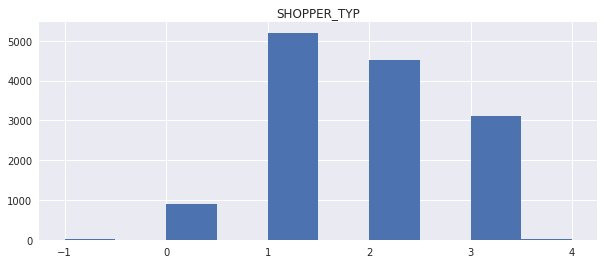

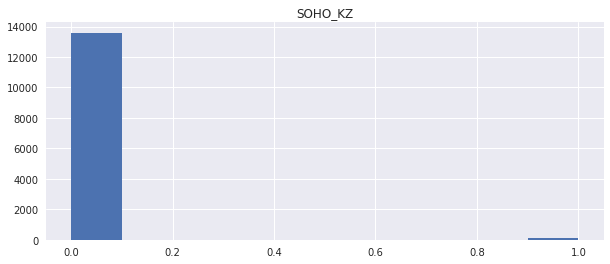

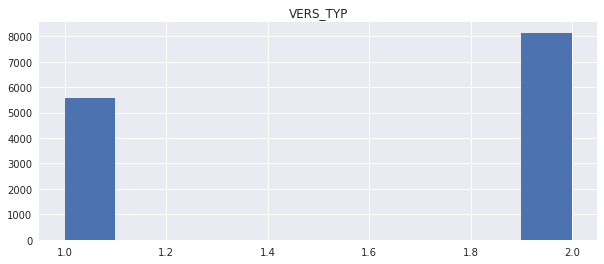

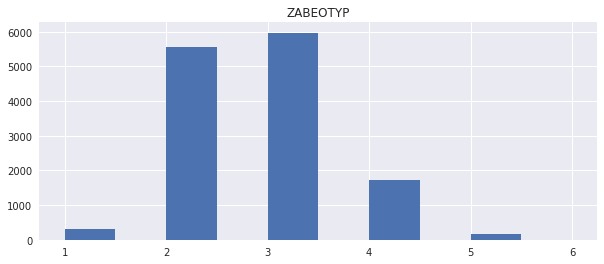

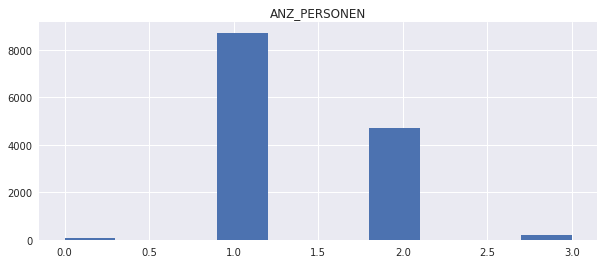

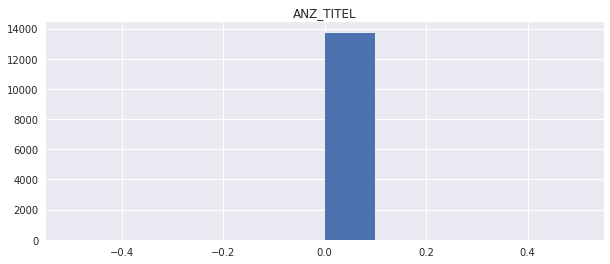

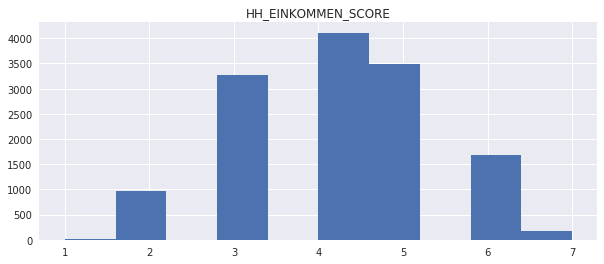

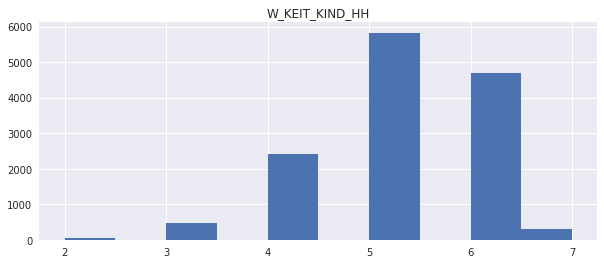

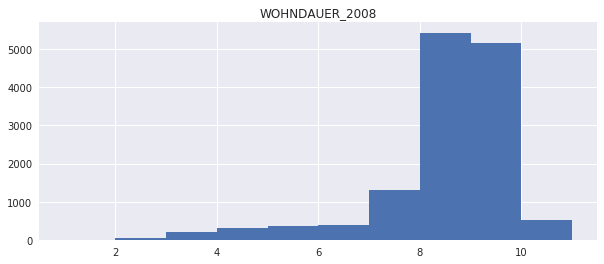

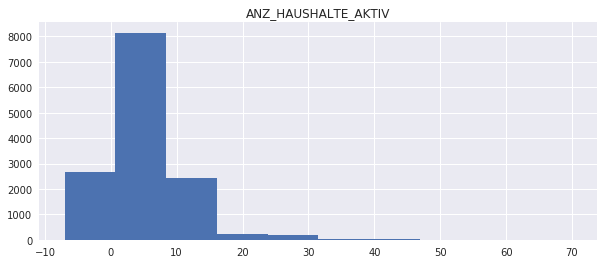

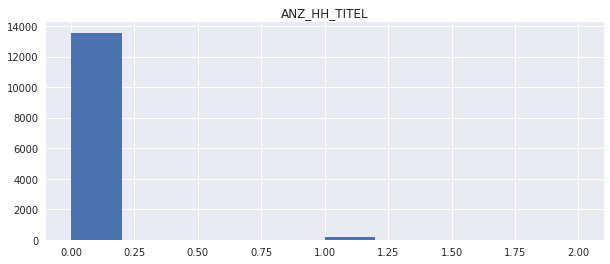

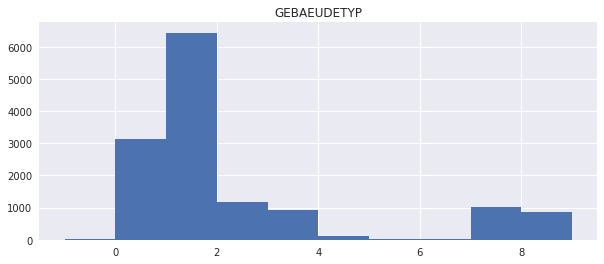

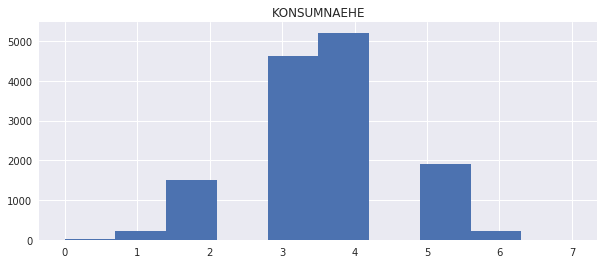

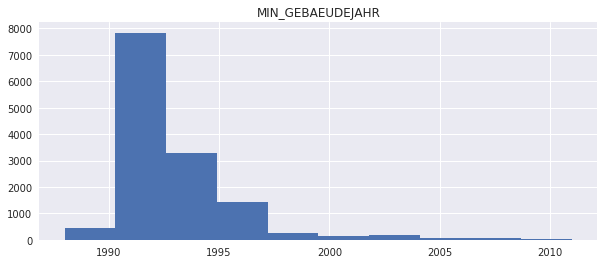

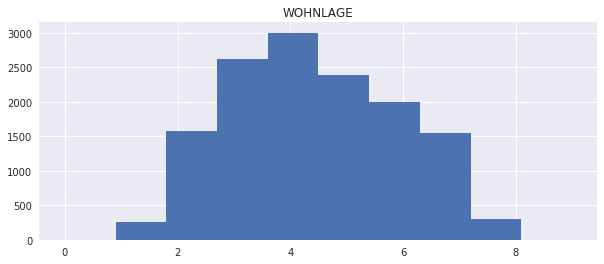

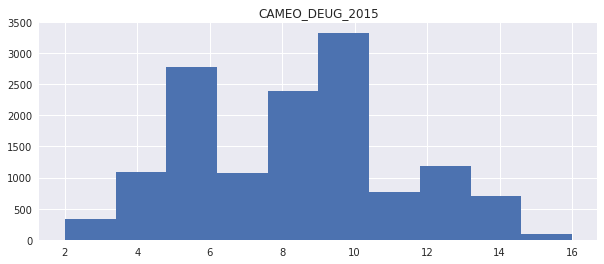

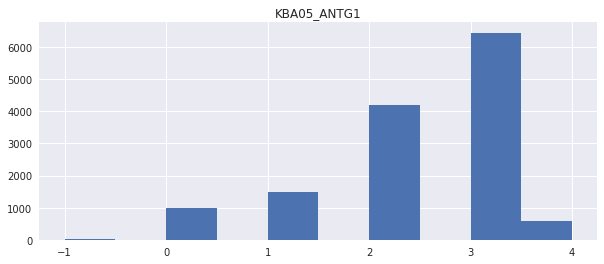

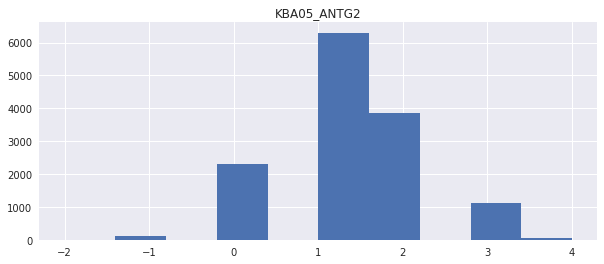

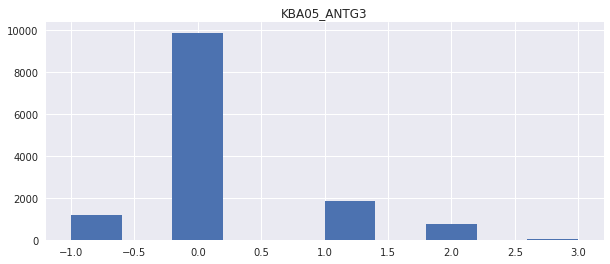

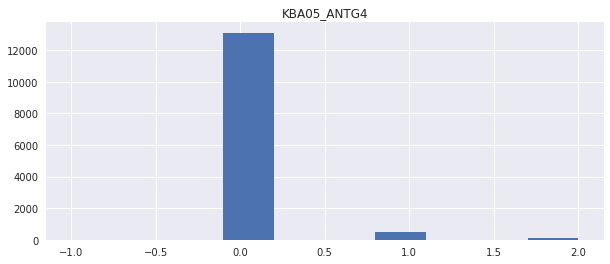

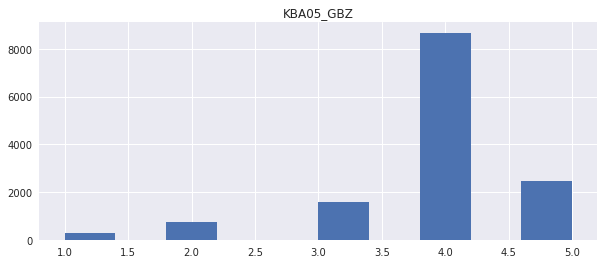

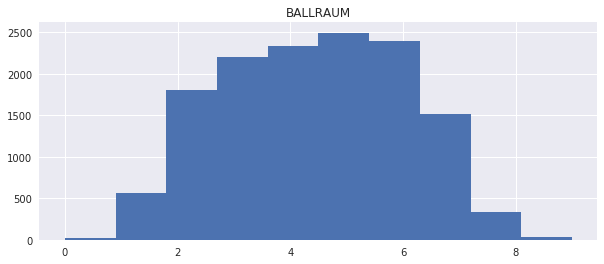

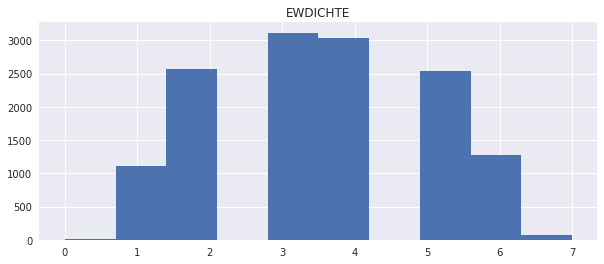

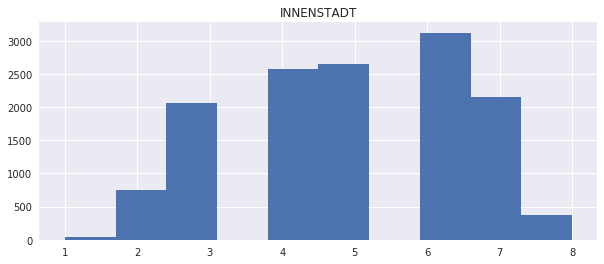

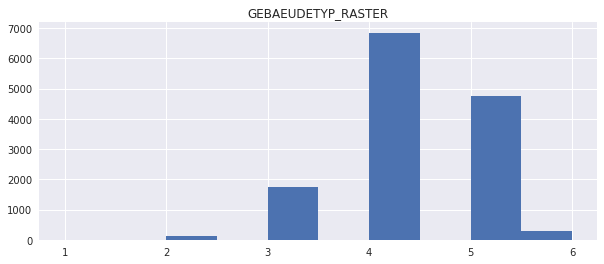

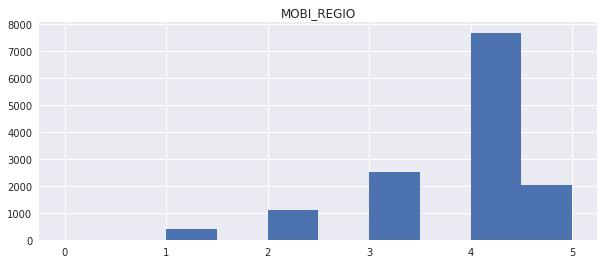

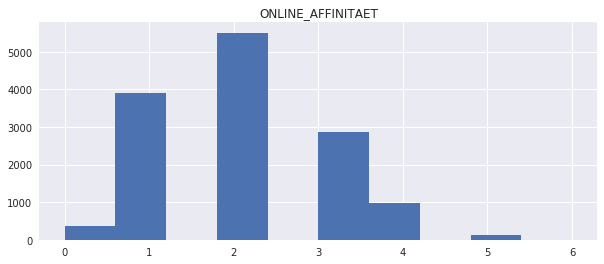

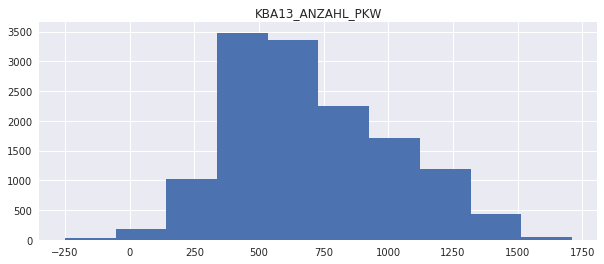

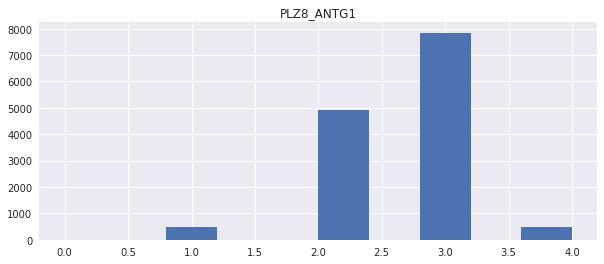

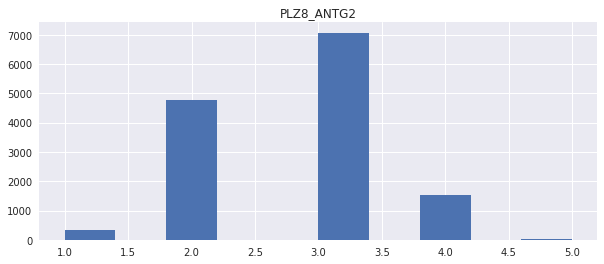

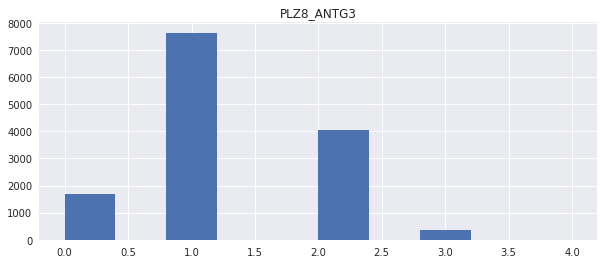

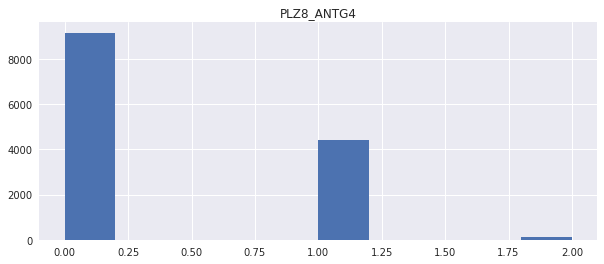

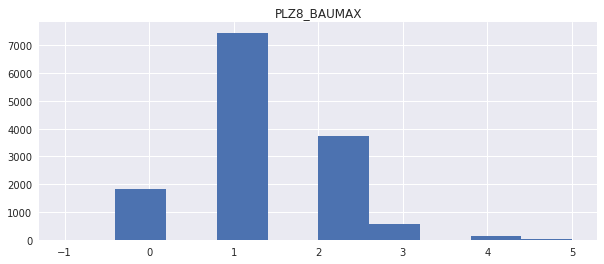

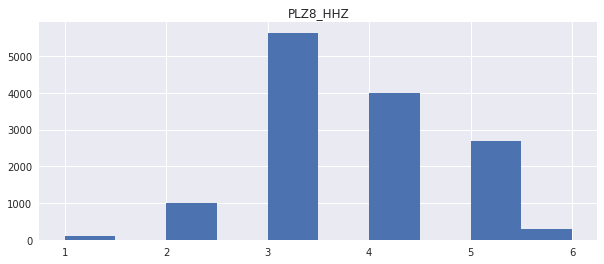

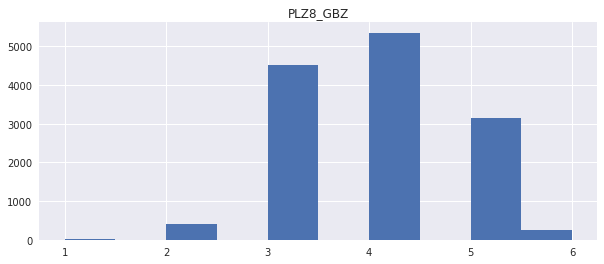

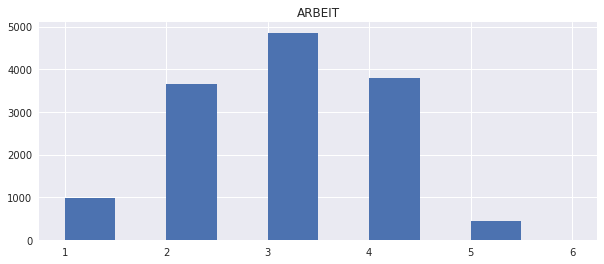

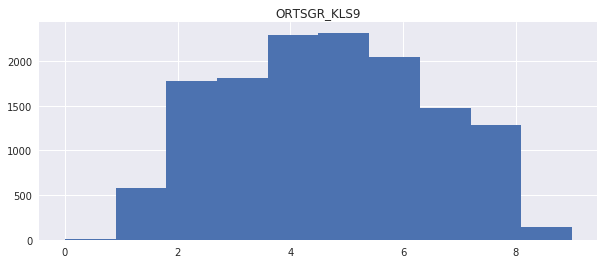

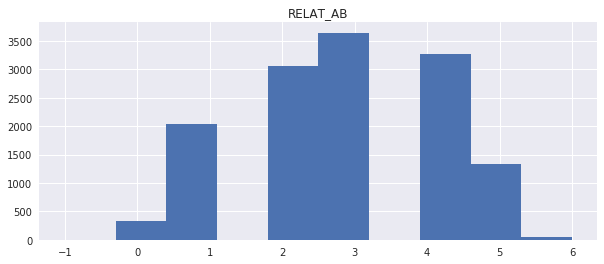

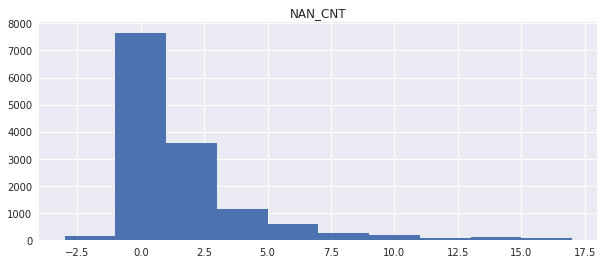

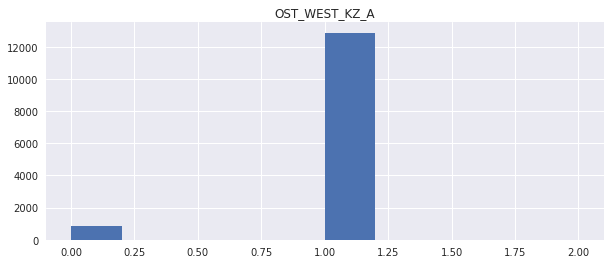

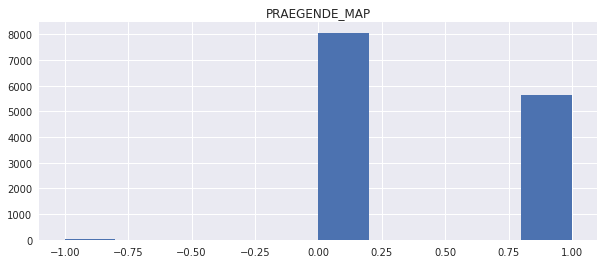

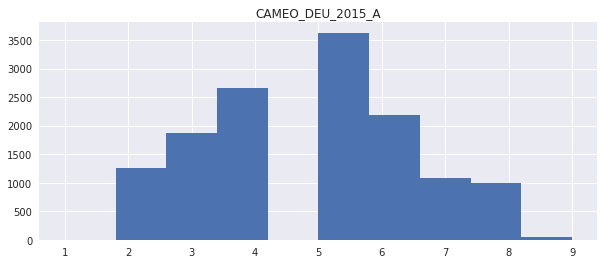

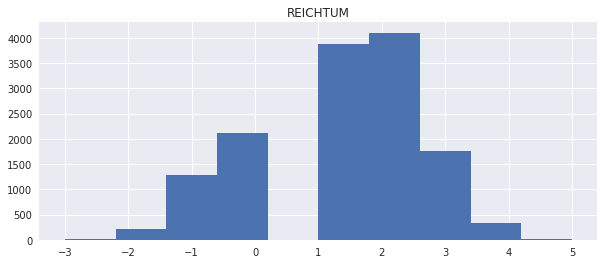

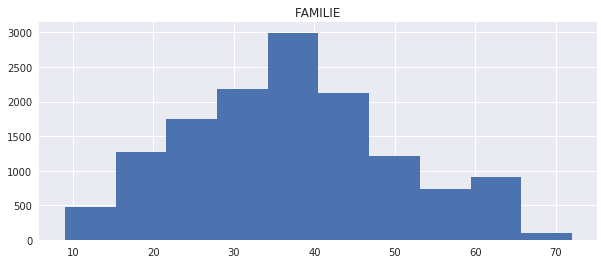

In [108]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over = scaler.inverse_transform(pca.inverse_transform(customers_PCA[np.where(pred_customers == 3)])).round()
df_over = pd.DataFrame(data = over, index=np.array(range(0, over.shape[0])),
                      columns= final_azdias.columns)

for col in df_over:
    df_over[col].value_counts()
    df_over[col].hist()
    plt.title(col)
    plt.show()              

In this group, the customers are overpresented in this group. Some of the characteristics of the customers are :
    - Ages 46- 60 approximately.(ALTERSKATEGORIE_GROB)
    - German speaking (NATIONALITAE_KZ)
    - Mostly female
    - And appear to be small households.
    

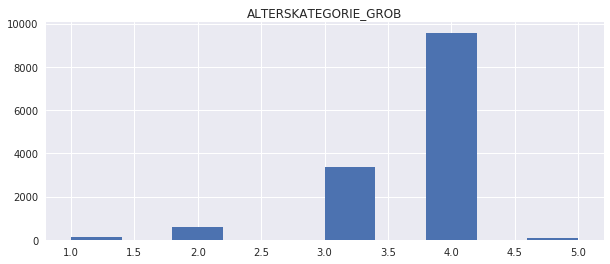

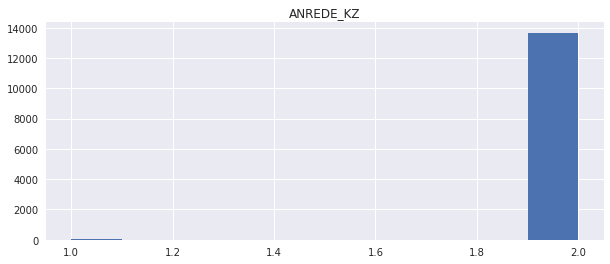

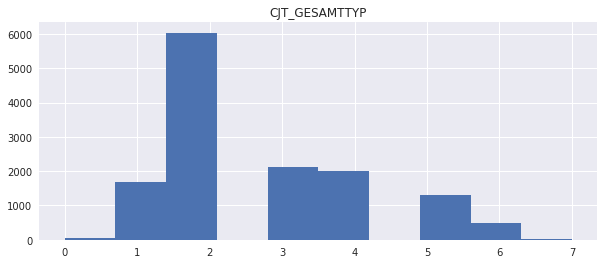

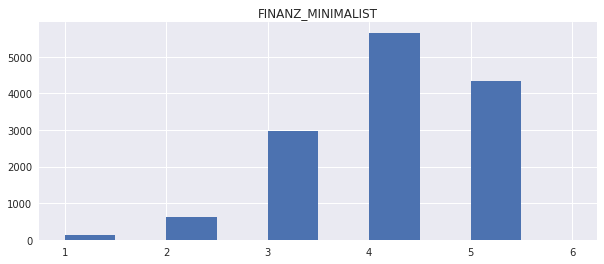

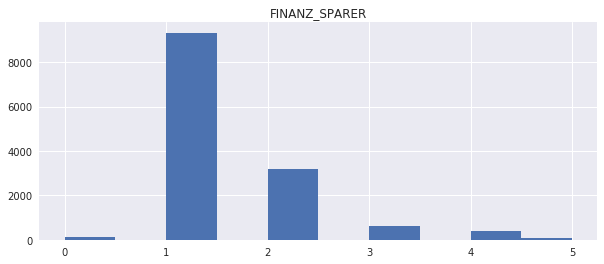

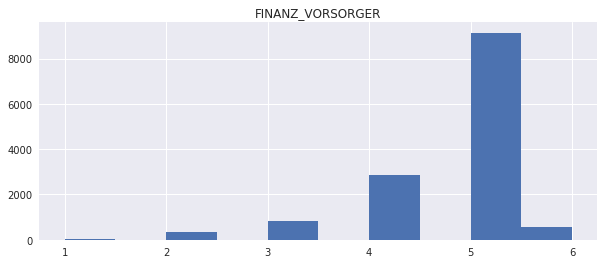

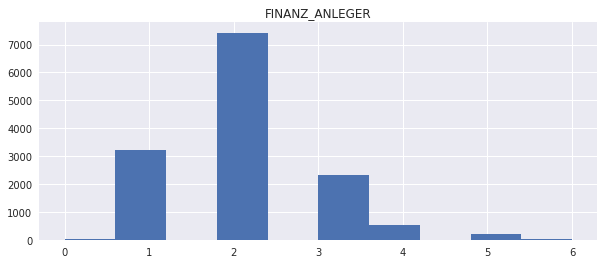

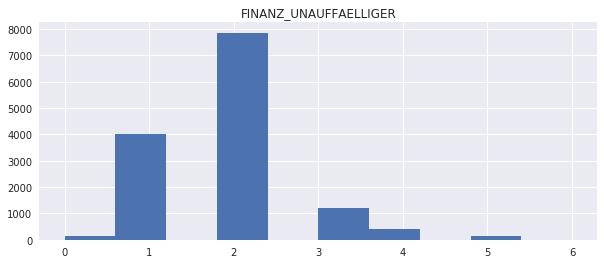

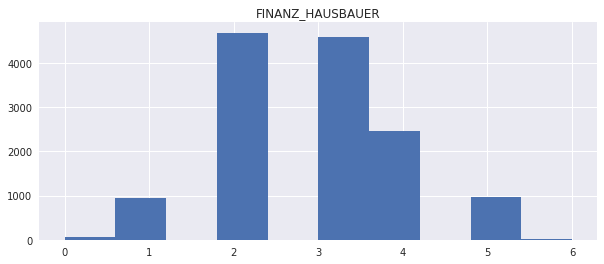

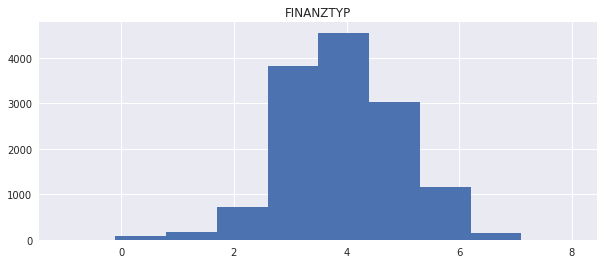

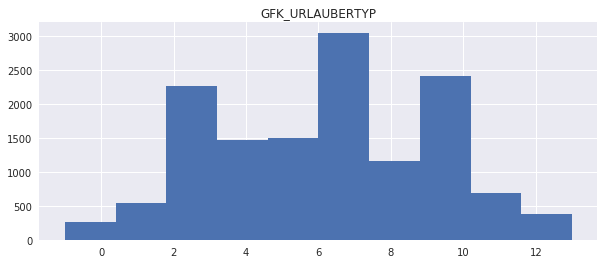

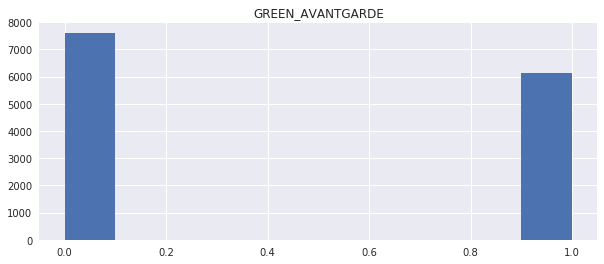

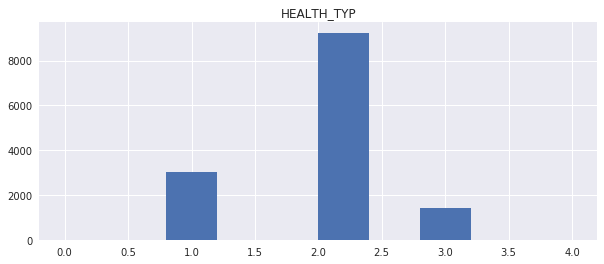

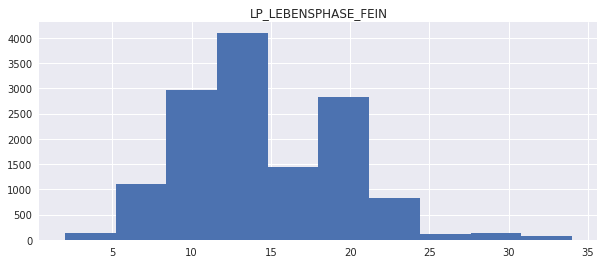

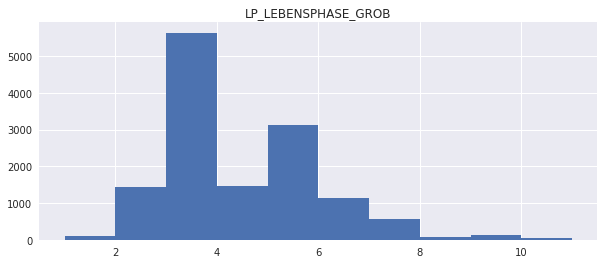

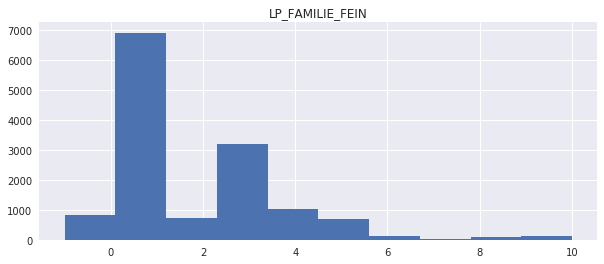

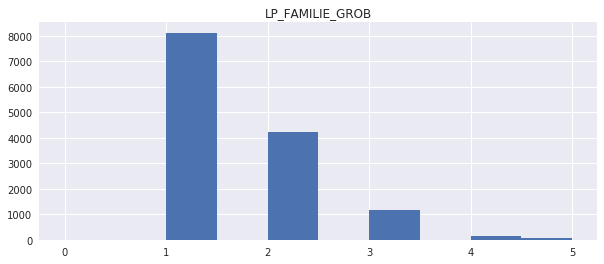

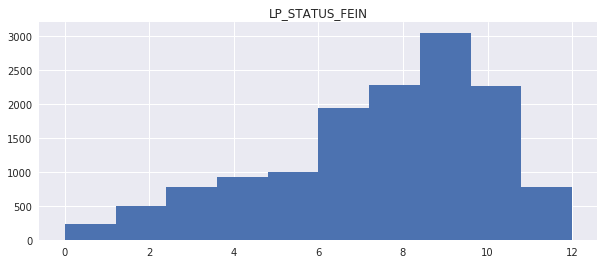

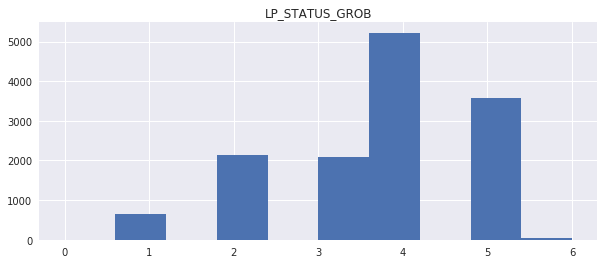

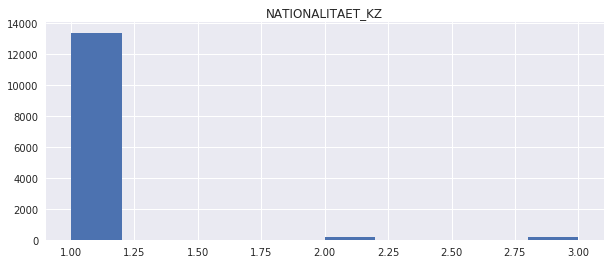

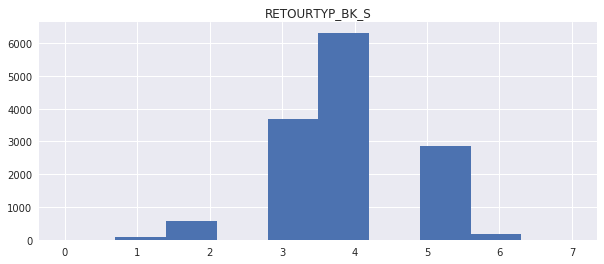

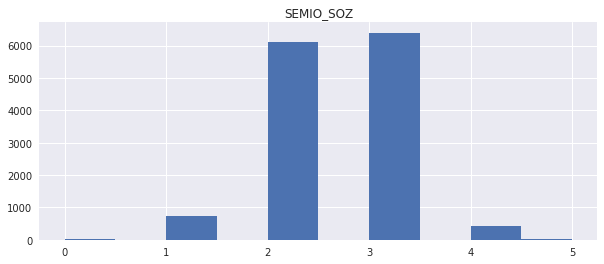

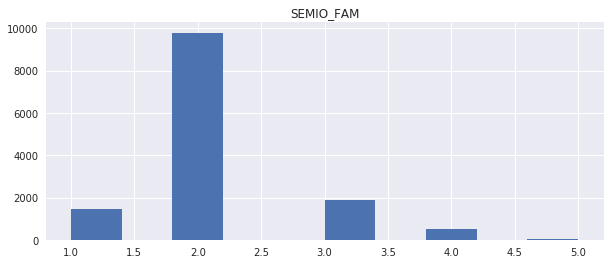

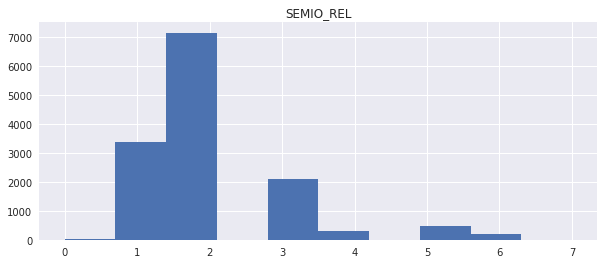

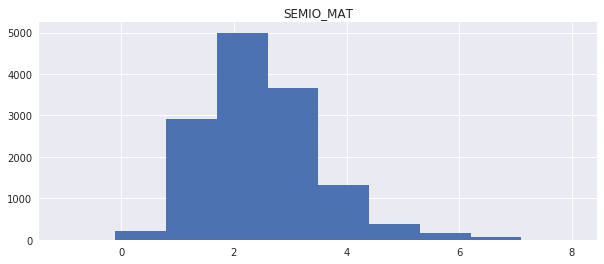

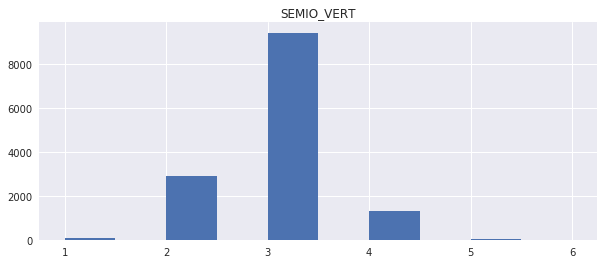

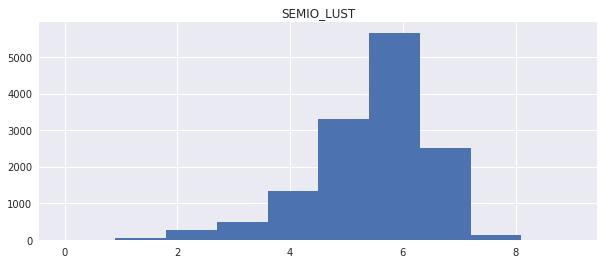

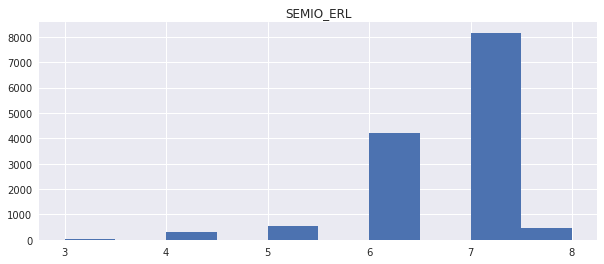

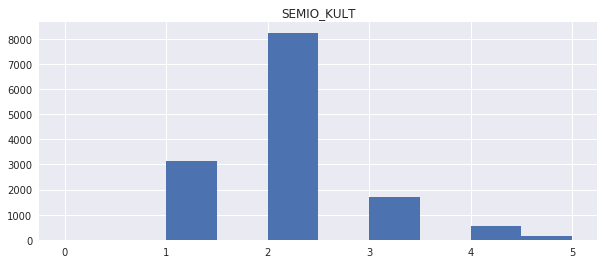

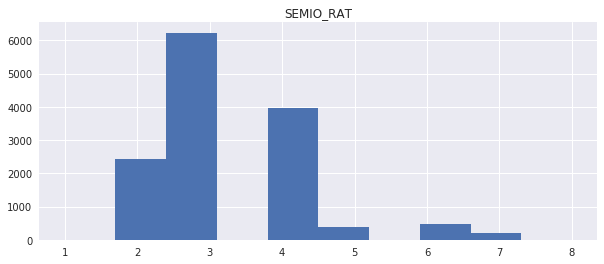

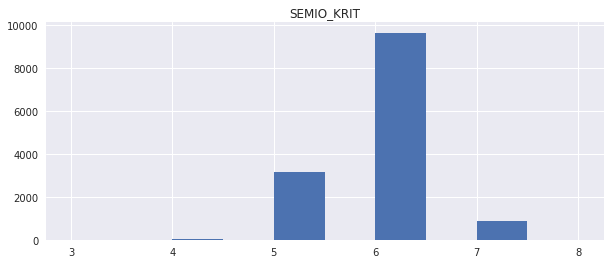

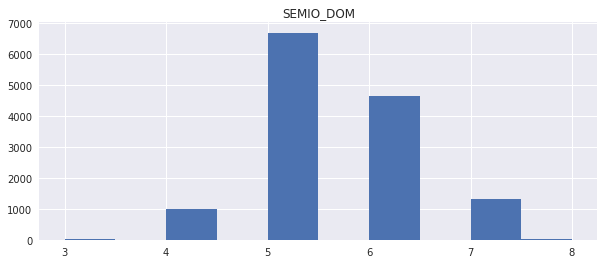

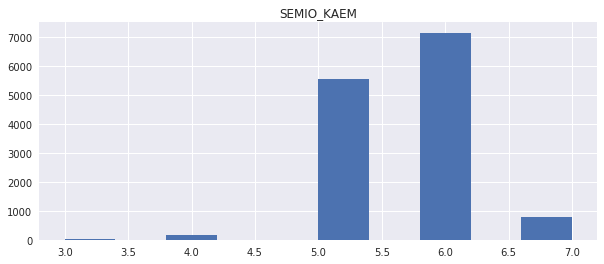

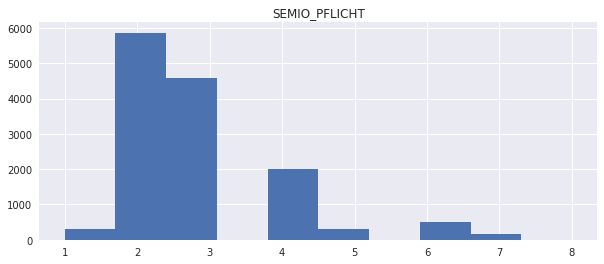

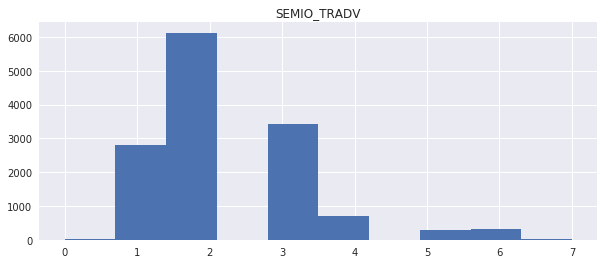

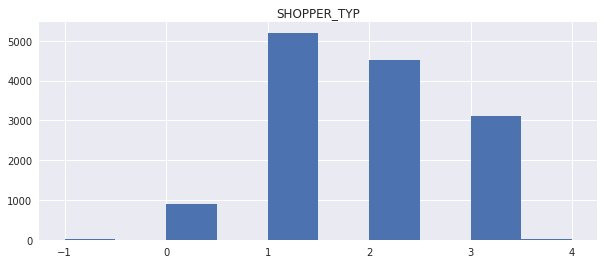

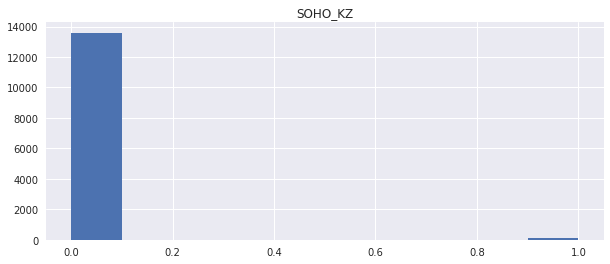

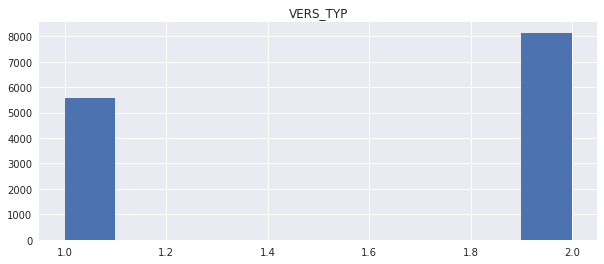

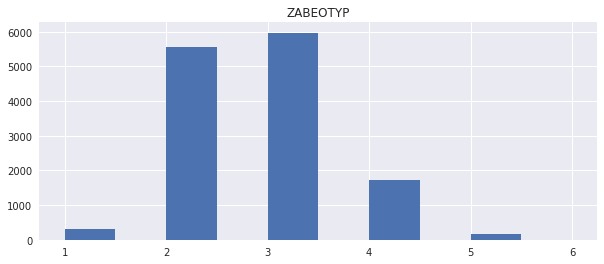

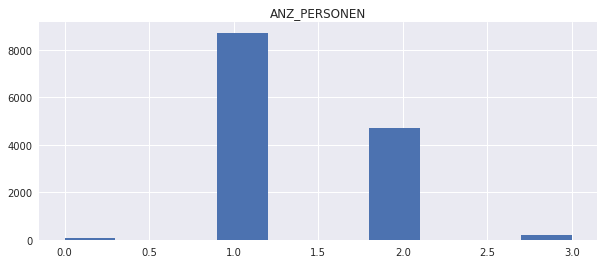

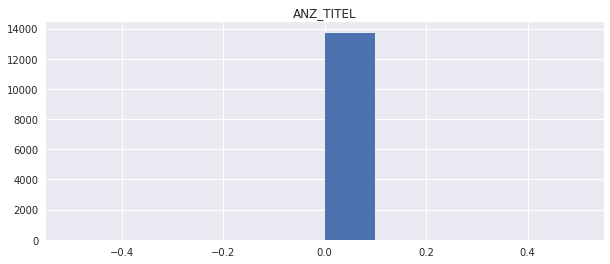

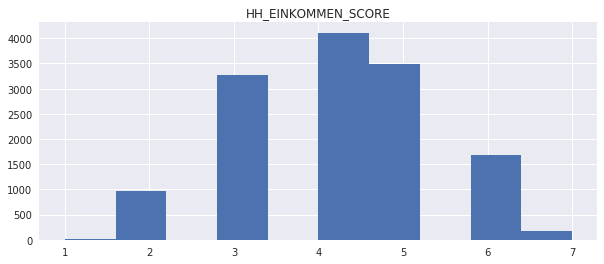

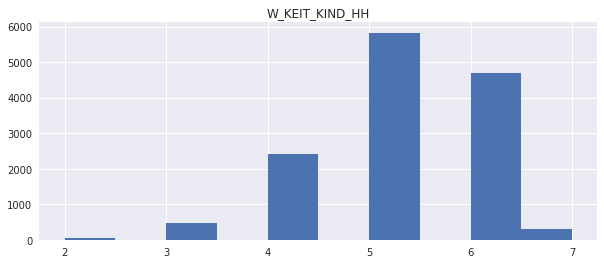

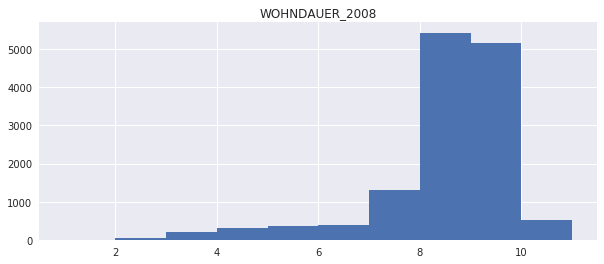

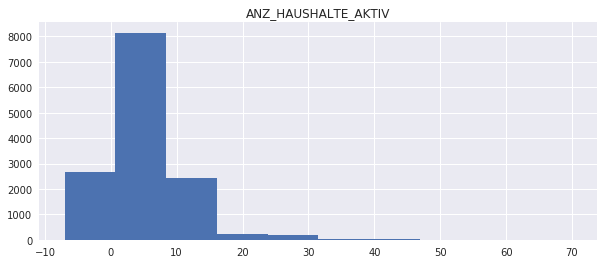

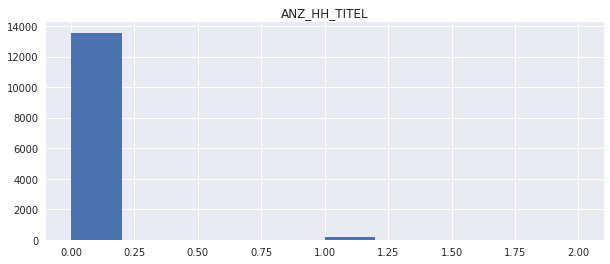

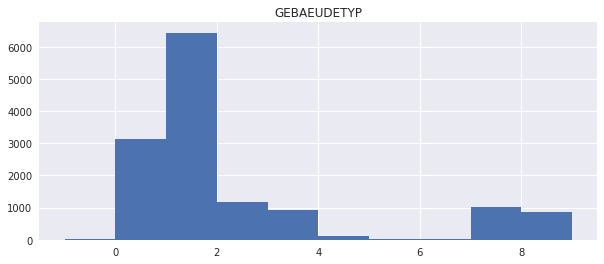

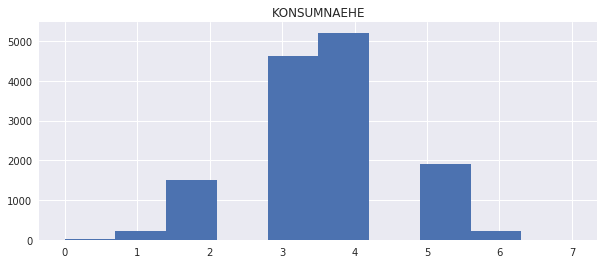

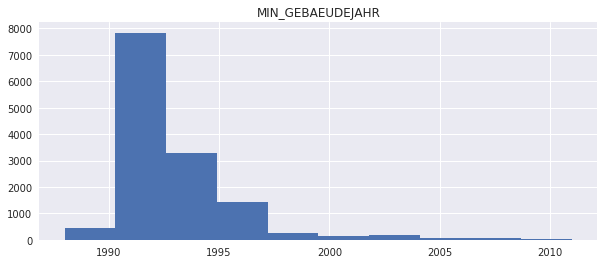

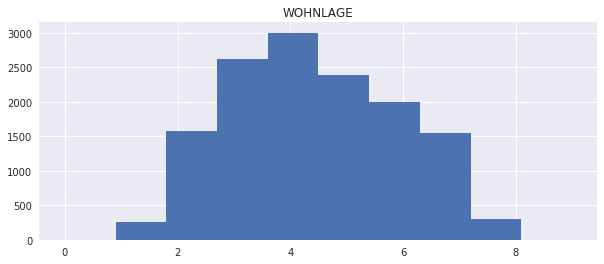

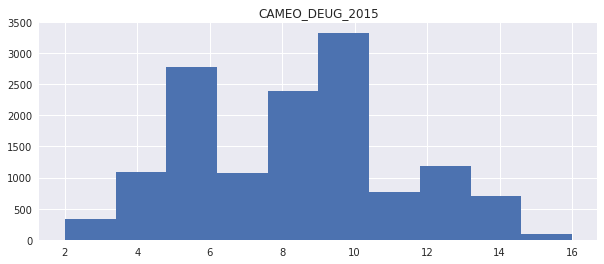

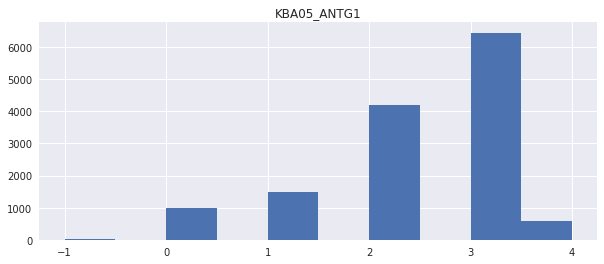

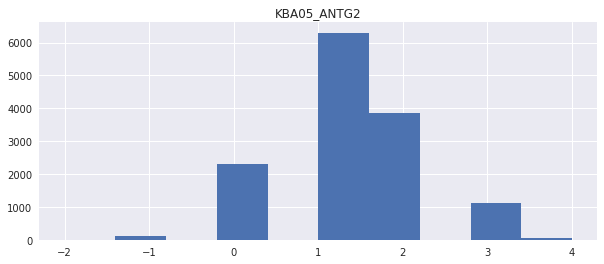

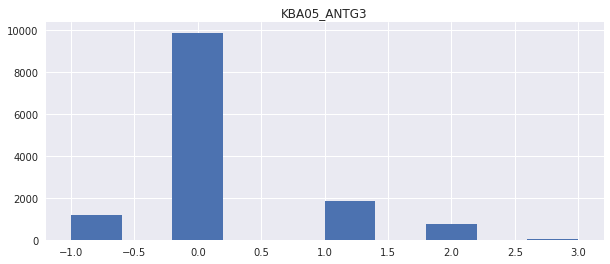

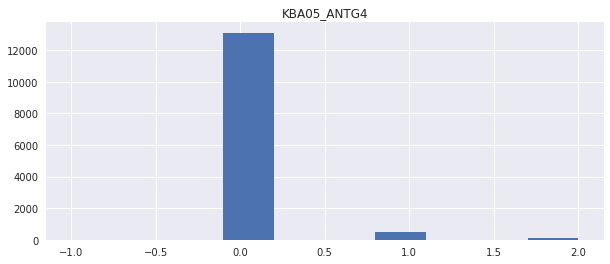

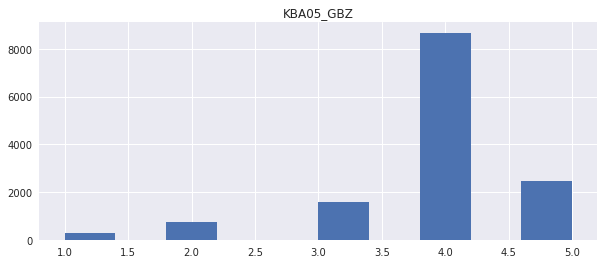

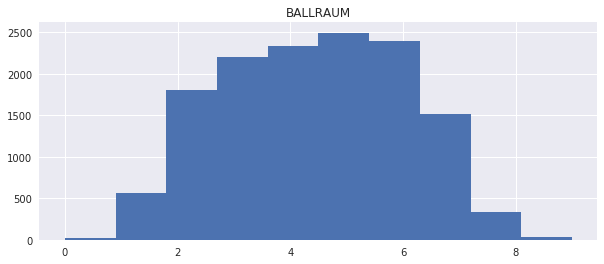

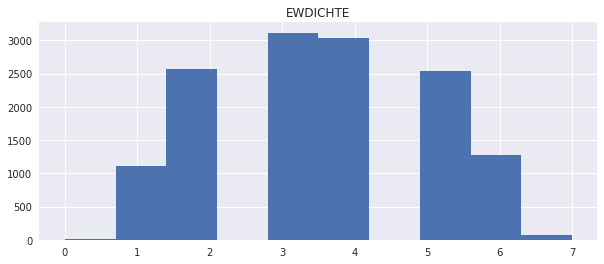

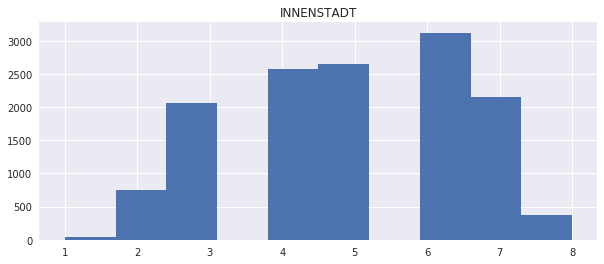

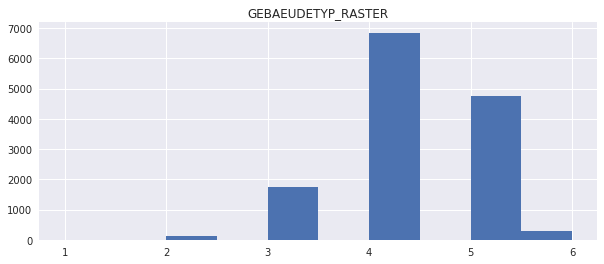

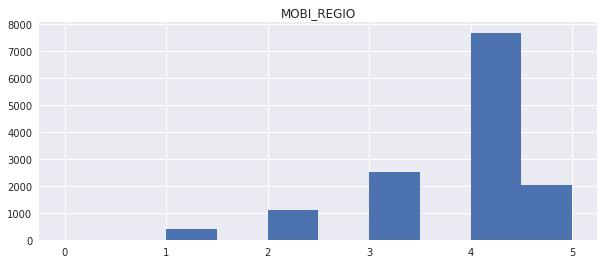

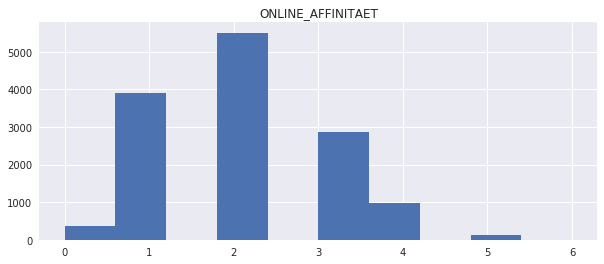

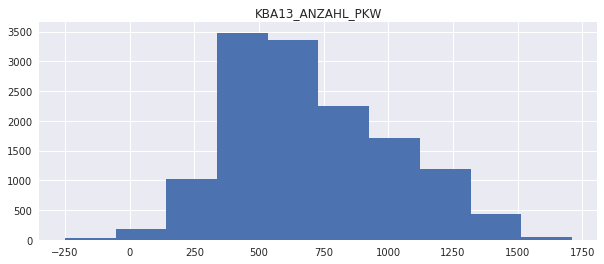

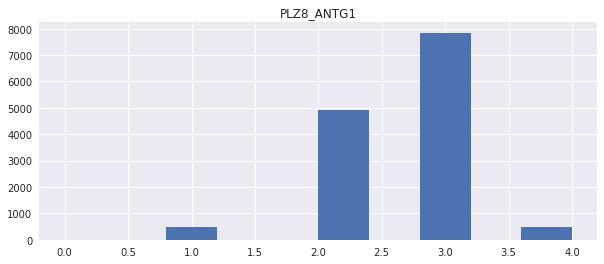

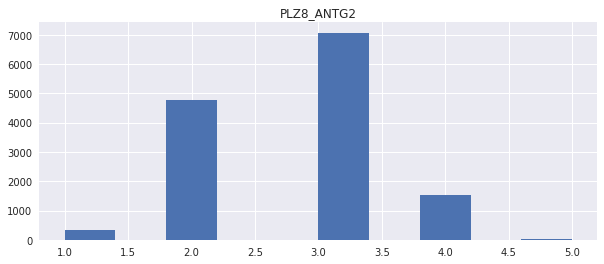

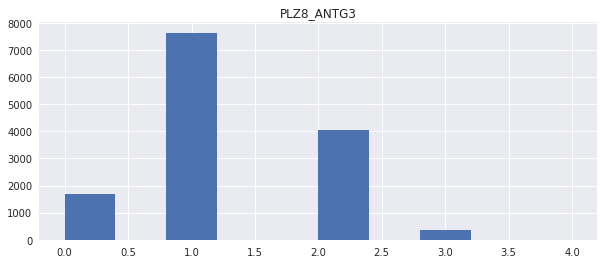

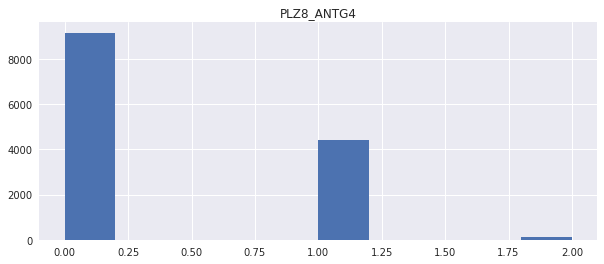

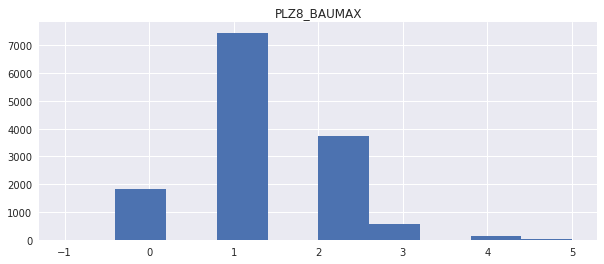

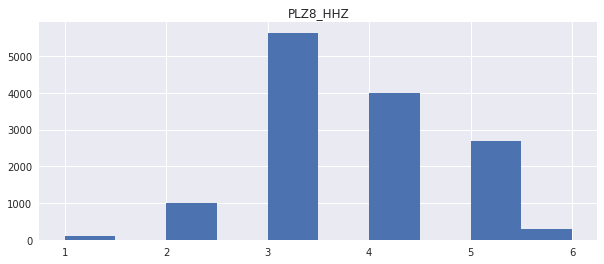

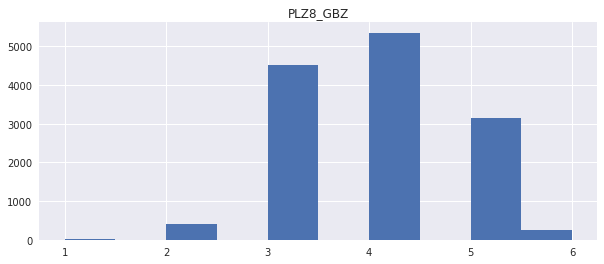

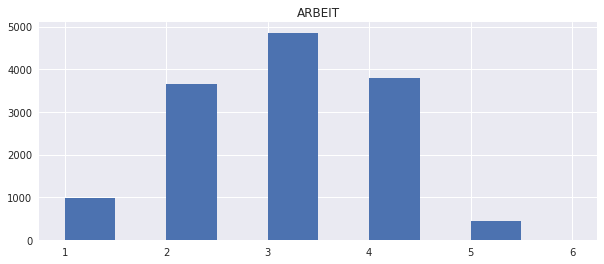

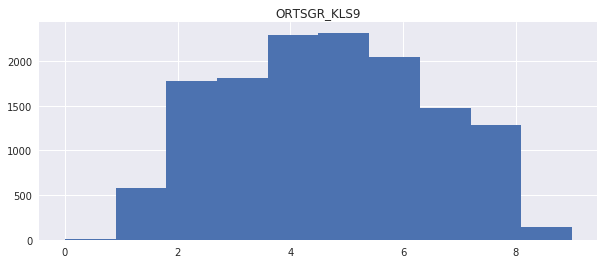

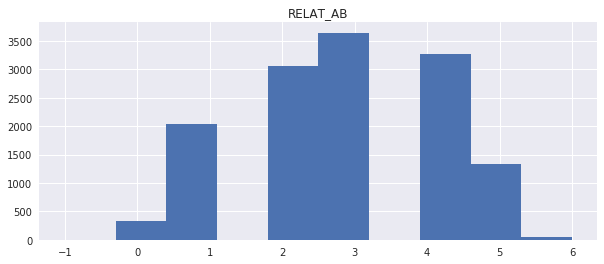

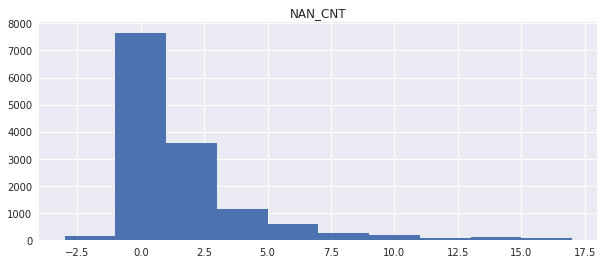

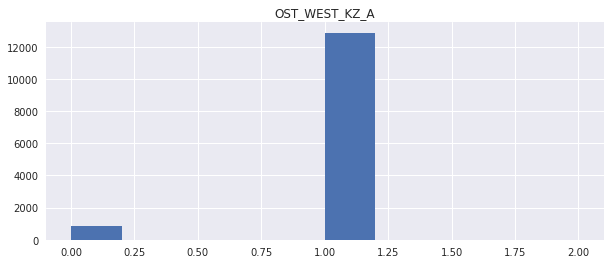

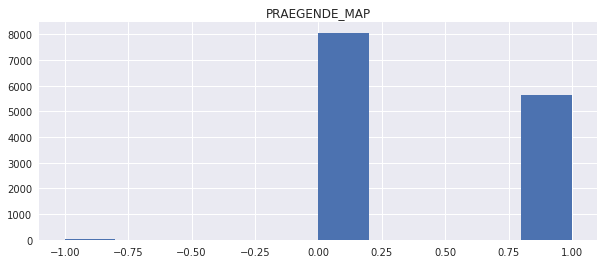

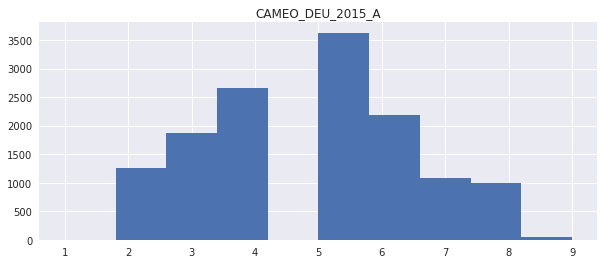

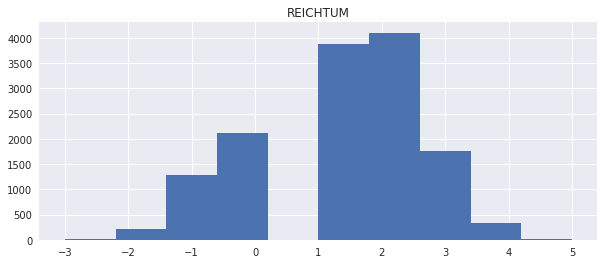

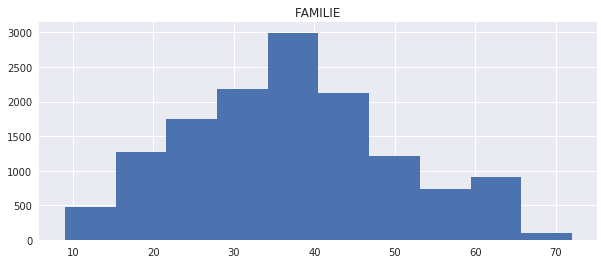

In [109]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under = scaler.inverse_transform(pca.inverse_transform(customers_PCA[np.where(pred_customers == 4)])).round()
df_under = pd.DataFrame(data = over, index=np.array(range(0, over.shape[0])),
                      columns= final_azdias.columns)

for col in df_under:
    df_under[col].hist()
    plt.title(col)
    plt.show()                    


This group the customers are under represented:
    - The over 60 age group
    - Multi- person households
    -family minded
    - Bigger households 
    - Very cuturally minded
    
    
    

### Discussion 3.3: Compare Customer Data to Demographics Data

The groups weren't that different between the demographics and the customers except for groups 4 and 5. It seems like they have a lot of shoppers that are from smaller homes/families. In order to really understand the customer, it would be best to work closer with azdias to learn more about their company and how this applies as well as test some marketing on the clusters. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

Resources used:
https://stackoverflow.com/questions/44195394/read-csv-file-with-semicolon-as-delimiter ,<br>
scipy.cluster.hierarchy.dendrogram — SciPy v0.14.0 Reference Guide <br>
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html <br>
Pandas Count Occurrences in Column - i.e. Unique Values <br>
https://www.marsja.se/pandas-count-occurrences-in-column-unique-values/ <br>
Count the NaN values in one or more columns in Pandas DataFrame - GeeksforGeeks <br>
https://www.geeksforgeeks.org/count-the-nan-values-in-one-or-more-columns-in-pandas-dataframe/ <br>
Create Histograms from Pandas DataFrames - wellsr.com\ <br>
https://wellsr.com/python/python-create-histogram-from-pandas-dataframe/ <br>
python - How do I check if a string is a negative number before passing it through int()? - Stack Overflow <br>
https://stackoverflow.com/questions/37472361/how-do-i-check-if-a-string-is-a-negative-number-before-passing-it-through-int <br>
python - Plotting Histogram for all columns in a Data Frame - Stack Overflow <br>
https://stackoverflow.com/questions/49780491/plotting-histogram-for-all-columns-in-a-data-frame <br>
python - Is a number float64? - Stack Overflow <br>
https://stackoverflow.com/questions/21254048/is-a-number-float64 <br>
python - Making histogram of object attribute of a DataFrame - Stack Overflow <br>
https://stackoverflow.com/questions/58358258/making-histogram-of-object-attribute-of-a-dataframe <br>
python - get list of pandas dataframe columns based on data type - Stack Overflow <br>
https://stackoverflow.com/questions/22470690/get-list-of-pandas-dataframe-columns-based-on-data-type <br>
pandas.DataFrame.drop — pandas 1.3.4 documentation <br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html <br>
python - Unable to drop a column from pandas dataframe - Stack Overflow <br>
https://stackoverflow.com/questions/38288372/unable-to-drop-a-column-from-pandas-dataframe <br>
count - Python/Pandas: counting the number of missing/NaN in each row - Stack Overflow <br>
https://stackoverflow.com/questions/30059260/python-pandas-counting-the-number-of-missing-nan-in-each-row <br>
python - How to iterate over rows in a DataFrame in Pandas - Stack Overflow <br>
https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas <br>
Seaborn countplot | What is the countplot? | Seaborn countplot vs barplot - YouTube <br>
https://www.youtube.com/watch?v=8U5h3EJuu8M <br>
Subplots with Matplotlib in Python - YouTube <br>
https://www.youtube.com/watch?v=Ql8QPcp8818 <br>
Matplotlib Tutorial (Part 10): Subplots - YouTube
https://www.youtube.com/watch?v=XFZRVnP-MTU <br>
seaborn.countplot — seaborn 0.11.2 documentation <br>
https://seaborn.pydata.org/generated/seaborn.countplot.html <br>
How to plot multiple sub-plots using Matplotlib and Seaborn | Session With Sumit - YouTube <br>
https://www.youtube.com/watch?v=4DnWYK88-E4 <br>
How do I create dummy variables in pandas? - YouTube <br>
https://www.youtube.com/watch?v=0s_1IsROgDc <br>
Input contains NaN when onehotencoding | Data Science and Machine Learning | Kaggle <br>
https://www.kaggle.com/getting-started/92041 <br>
How do I handle missing values in pandas? - YouTube <br>
https://www.youtube.com/watch?v=fCMrO_VzeL8 <br>
Most Germans consider themselves middle class: study - Xinhua | English.news.cn <br>
http://www.xinhuanet.com/english/2019-08/12/c_138303931.htm <br>
Interpolation | Interpolation in Python to Fill Missing Values <br>
https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/ <br>
neural network - When should I use StandardScaler and when MinMaxScaler? - Data Science Stack Exchange <br>
https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler <br>
How to Create a Scree Plot in Python (Step-by-Step) - Statology
https://www.statology.org/scree-plot-python/ <br>
How Can We Identify Customer Segments Using the Cluster Method? | by Haitian Wei | DataDrivenInvestor <br>
https://medium.datadriveninvestor.com/how-can-we-identify-customer-segments-using-cluster-method-94a58ddba772 <br>
How to keep Time in Python - Kite <br>
https://www.kite.com/python/answers/how-to-keep-time-in-python <br>




